Importing Libraries

In [ ]:
!pip install nibabel scipy pandas
import pandas as pd
import nibabel as nib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import glob


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import gc

Mounting the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Listing Files in the Drive

In [ ]:
fmri_files = os.listdir('/content/drive/MyDrive/Datasets/FMRI/')
print("Files in FMRI directory:", fmri_files)


Files in FMRI directory: ['fmri_szxxx0040044_session1_run1_extra.mat', 'fmri_szxxx0040072_session1_run1_extra.mat', 'fmri_szxxx0040064_session1_run1.nii.gz', 'fmri_szxxx0040073_session1_run1_extra.mat', 'fmri_szxxx0040075_session1_run1_extra.mat', 'fmri_szxxx0040078_session1_run1_extra.mat', 'fmri_szxxx0040073_session1_run1.nii.gz', 'fmri_szxxx0040075_session1_run1.nii.gz', 'fmri_szxxx0040072_session1_run1.nii.gz', 'fmri_szxxx0040077_session1_run1_extra.mat', 'fmri_szxxx0040071_session1_run1.nii.gz', 'fmri_szxxx0040079_session1_run1_extra.mat', 'fmri_szxxx0040078_session1_run1.nii.gz', 'fmri_szxxx0040071_session1_run1_extra.mat', 'fmri_szxxx0040037_session1_run1.nii.gz', 'fmri_szxxx0040047_session1_run1_extra.mat', 'fmri_szxxx0040047_session1_run1.nii.gz', 'fmri_szxxx0040046_session1_run1_extra.mat', 'fmri_szxxx0040046_session1_run1.nii.gz', 'fmri_szxxx0040049_session1_run1.nii.gz', 'fmri_szxxx0040049_session1_run1_extra.mat', 'fmri_szxxx0040059_session1_run1_extra.mat', 'fmri_szxxx004

In [ ]:
base_path = '/content/drive/MyDrive/Datasets/FMRI/'

Reading FMRI data from meta csv


In [ ]:
metadata_file = os.path.join(base_path, 'cobre_group.csv')
metadata=pd.read_csv(metadata_file)

In [ ]:
print(metadata.head())
print(metadata.tail())

     subject_id  sz  age  sex    FD
0  szxxx0040000   1   20    1  0.18
1  szxxx0040001   1   27    0  0.50
2  szxxx0040002   1   19    0  0.21
3  szxxx0040003   1   28    0  0.23
4  szxxx0040004   1   55    0  0.14
         subject_id  sz  age  sex    FD
141  contxxx0040140   0   53    1  0.25
142  contxxx0040141   0   35    1  0.22
143  contxxx0040144   0   54    0  0.30
144  contxxx0040146   0   39    0  0.19
145  contxxx0040147   0   34    0  0.24


In [ ]:
metadata.columns

Index(['subject_id', 'sz', 'age', 'sex', 'FD'], dtype='object')

Loading mat file

In [ ]:
import scipy.io as sio

def load_mat_file(subject_id):
    mat_file = os.path.join(base_path, f'fmri_{subject_id}_session1_run1_extra.mat')

    if os.path.exists(mat_file):
        mat_data = sio.loadmat(mat_file)
        return mat_data
    else:
        print(f"File not found for subject: {subject_id}")
        return None

# Example: Load the .mat file for the first subject in the metadata
subject_id = metadata['subject_id'].iloc[0]
mat_data = load_mat_file(subject_id)

# Check if the file was loaded
if mat_data is not None:
    print(mat_data.keys())
else:
    print(f"No data available for subject {subject_id}")


dict_keys(['__header__', '__version__', '__globals__', 'confounds', 'labels_confounds', 'mask_suppressed', 'time_frames'])


Loading nifti file

In [ ]:
import nibabel as nib

def load_nifti_file(subject_id):
    nifti_file = os.path.join(base_path, f'fmri_{subject_id}_session1_run1.nii.gz')

    if os.path.exists(nifti_file):
        img = nib.load(nifti_file)
        data = img.get_fdata()
        return data, img.affine, img.header
    else:
        print(f"File not found for subject: {subject_id}")
        return None, None, None

# Example: Load the .nii.gz file for the first subject in the metadata
nifti_data, affine, header = load_nifti_file(subject_id)

# Check if the file was loaded
if nifti_data is not None:
    print(nifti_data.shape)
else:
    print(f"No data available for subject {subject_id}")

(53, 64, 52, 146)


Initial Preprocessing, Normailising and linking files

In [ ]:
batch_size = 10
# Initialize an empty list to hold all processed data
all_data = []

# Function to load the .mat file
def load_mat_file(subject_id):
    mat_file = os.path.join(base_path, f'fmri_{subject_id}_session1_run1_extra.mat')
    if os.path.exists(mat_file):
        mat_data = sio.loadmat(mat_file)
        return mat_data
    else:
        print(f"MAT file not found for subject: {subject_id}")
        return None

# Function to load and normalize fMRI data
def load_and_normalize_nifti_file(subject_id):
    nifti_file = os.path.join(base_path, f'fmri_{subject_id}_session1_run1.nii.gz')
    if os.path.exists(nifti_file):
        img = nib.load(nifti_file)
        data = img.get_fdata()

        # Normalize the fMRI data
        mean = np.mean(data, axis=(0, 1, 2))
        std = np.std(data, axis=(0, 1, 2))
        normalized_data = (data - mean) / std

        return normalized_data, img.affine, img.header
    else:
        print(f"NIfTI file not found for subject: {subject_id}")
        return None, None, None

# Function to process a batch of subjects
def process_batch(batch_metadata):
    batch_results = []

    for idx, row in batch_metadata.iterrows():
        subject_id = row['subject_id']

        # Load the .mat file
        mat_data = load_mat_file(subject_id)

        # Load and normalize the .nii.gz file
        nifti_data, affine, header = load_and_normalize_nifti_file(subject_id)

        # If both .mat and .nii.gz files are successfully loaded
        if mat_data is not None and nifti_data is not None:
            subject_data = {
                'subject_id': subject_id,
                'metadata': row,  # The entire row of metadata
                'mat_data': mat_data,  # The .mat file data
                'nifti_data': nifti_data,  # The normalized fMRI data
                'affine': affine,  # The affine transformation matrix
                'header': header  # The header information from the NIfTI file
            }

            # Append this subject's data to the batch results
            batch_results.append(subject_data)

        # Memory cleanup after processing each subject
        del nifti_data, mat_data
        gc.collect()

    return batch_results

# Process data in batches
total_subjects = len(metadata)
for start_idx in range(0, total_subjects, batch_size):
    end_idx = min(start_idx + batch_size, total_subjects)
    print(f'Processing batch {start_idx + 1} to {end_idx}')

    # Select the current batch of metadata
    batch_metadata = metadata.iloc[start_idx:end_idx]

    # Process the current batch
    batch_results = process_batch(batch_metadata)

    # Append batch results to the overall data
    all_data.extend(batch_results)

    # Clean up memory
    del batch_results
    gc.collect()

# Convert all the processed data into a DataFrame for easier handling
data_df = pd.DataFrame(all_data)

# Display the first few entries to check
print(data_df.head())

Processing batch 1 to 10
Processing batch 11 to 20
Processing batch 21 to 30
Processing batch 31 to 40
Processing batch 41 to 50
Processing batch 51 to 60
Processing batch 61 to 70
Processing batch 71 to 80
Processing batch 81 to 90
Processing batch 91 to 100
Processing batch 101 to 110
Processing batch 111 to 120
Processing batch 121 to 130
Processing batch 131 to 140
Processing batch 141 to 146
     subject_id                                           metadata  \
0  szxxx0040000  subject_id    szxxx0040000
sz                 ...   
1  szxxx0040001  subject_id    szxxx0040001
sz                 ...   
2  szxxx0040002  subject_id    szxxx0040002
sz                 ...   
3  szxxx0040003  subject_id    szxxx0040003
sz                 ...   
4  szxxx0040004  subject_id    szxxx0040004
sz                 ...   

                                            mat_data  \
0  {'__header__': b'MATLAB 5.0 MAT-file, written ...   
1  {'__header__': b'MATLAB 5.0 MAT-file, written ...   
2  {'__head

Exploratory Data Analysis

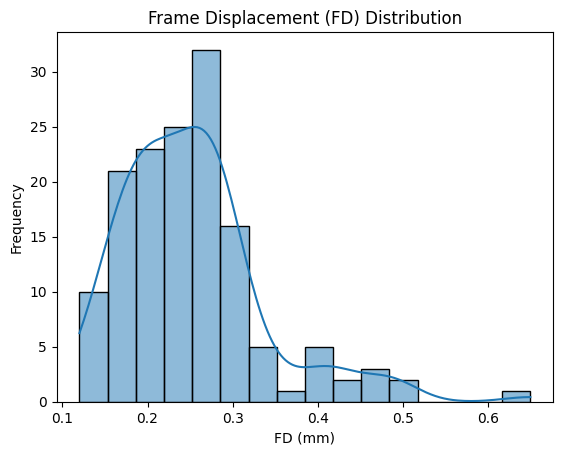

In [ ]:
sns.histplot(data_df['metadata'].apply(lambda x: x['FD']), kde=True)
plt.title('Frame Displacement (FD) Distribution')
plt.xlabel('FD (mm)')
plt.ylabel('Frequency')
plt.show()

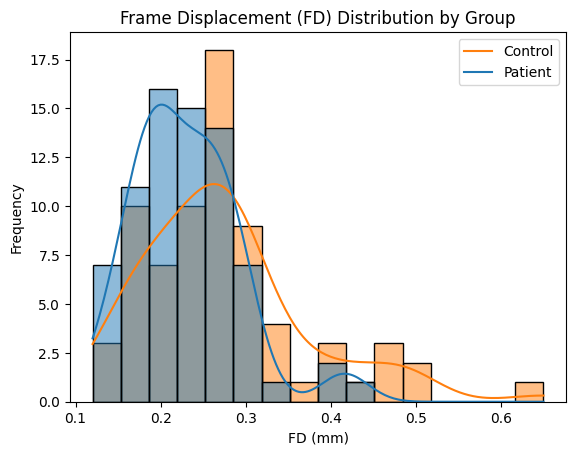

In [ ]:
# Compare FD distribution between controls and patients
sns.histplot(data=data_df, x=data_df['metadata'].apply(lambda x: x['FD']), hue=data_df['metadata'].apply(lambda x: x['sz']), kde=True)
plt.title('Frame Displacement (FD) Distribution by Group')
plt.xlabel('FD (mm)')
plt.ylabel('Frequency')
plt.legend(['Control', 'Patient'])
plt.show()

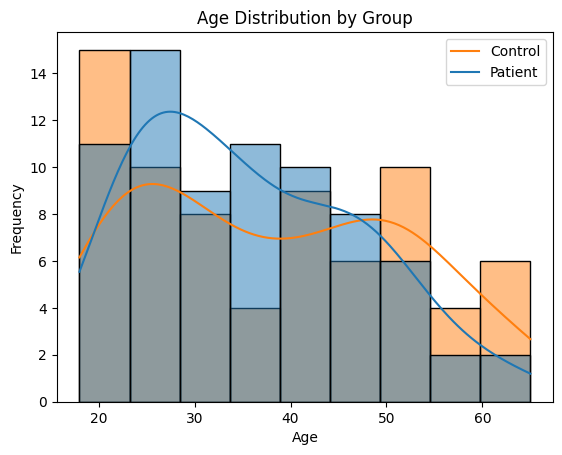

In [ ]:
# Check age distribution between controls and patients
sns.histplot(data=data_df, x=data_df['metadata'].apply(lambda x: x['age']), hue=data_df['metadata'].apply(lambda x: x['sz']), kde=True)
plt.title('Age Distribution by Group')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(['Control', 'Patient'])
plt.show()

In [ ]:
# Check sex distribution between controls and patients
control_sex = data_df[data_df['metadata'].apply(lambda x: x['sz'] == 0)]['metadata'].apply(lambda x: x['sex']).value_counts()
patient_sex = data_df[data_df['metadata'].apply(lambda x: x['sz'] == 1)]['metadata'].apply(lambda x: x['sex']).value_counts()

print('Sex distribution in Controls:')
print(control_sex)

print('Sex distribution in Patients:')
print(patient_sex)

Sex distribution in Controls:
metadata
0    51
1    23
Name: count, dtype: int64
Sex distribution in Patients:
metadata
0    58
1    14
Name: count, dtype: int64


In [ ]:
def check_remaining_time_frames(mat_data):
    mask_suppressed = mat_data.get('mask_suppressed', None)
    if mask_suppressed is not None:
        remaining_frames = np.sum(mask_suppressed == 0)  # Frames kept after scrubbing
    else:
        remaining_frames = None
    return remaining_frames

# Add the number of remaining frames to the DataFrame
data_df['remaining_frames'] = data_df['mat_data'].apply(check_remaining_time_frames)

# Check for subjects with fewer than 60 frames
subjects_below_threshold = data_df[data_df['remaining_frames'] < 60]
print(f'Subjects with fewer than 60 time frames:\n{subjects_below_threshold[["subject_id", "remaining_frames"]]}')


Subjects with fewer than 60 time frames:
         subject_id  remaining_frames
1      szxxx0040001                40
5      szxxx0040005                40
7      szxxx0040007                40
9      szxxx0040009                40
11     szxxx0040011                40
12     szxxx0040012                46
13     szxxx0040015                40
14     szxxx0040016                40
23     szxxx0040039                40
24     szxxx0040040                40
26     szxxx0040042                41
27     szxxx0040044                40
30     szxxx0040049                40
32     szxxx0040060                40
34     szxxx0040071                40
36     szxxx0040073                40
37     szxxx0040075                40
43     szxxx0040082                40
44     szxxx0040084                40
46     szxxx0040088                40
47     szxxx0040089                40
49     szxxx0040094                59
50     szxxx0040096                45
51     szxxx0040097                40
54     sz

In [ ]:
# Get the value counts of remaining frames below 60
value_counts_below_60 = subjects_below_threshold['remaining_frames'].value_counts()
print(f'Value counts of remaining frames below 60:\n{value_counts_below_60}')

Value counts of remaining frames below 60:
remaining_frames
40    34
45     2
59     2
53     2
41     1
46     1
42     1
47     1
49     1
Name: count, dtype: int64


Visualizing Mri files

In [ ]:
fmri_img1 = nib.load('/content/drive/MyDrive/Datasets/FMRI/fmri_szxxx0040044_session1_run1.nii.gz')
fmri_data1 = fmri_img1.get_fdata()
print(f"fMRI data shape: {fmri_data1.shape}")

fMRI data shape: (53, 64, 52, 40)


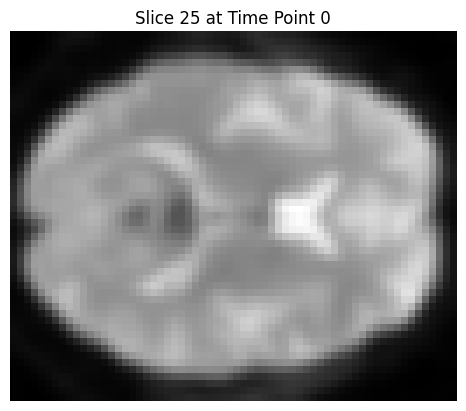

In [ ]:
import matplotlib.pyplot as plt

# Select a specific time point and slice index
time_point = 0  # The first time point
slice_index = 25  # You can adjust this to view different slices

# Extract the slice at the specific time point
slice_img = fmri_data1[:, :, slice_index, time_point]

# Display the slice
plt.imshow(slice_img, cmap='gray')
plt.title(f'Slice {slice_index} at Time Point {time_point}')
plt.axis('off')  # Hide axes
plt.show()

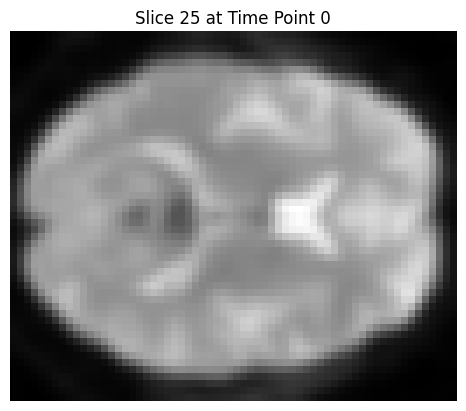

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

# Define the slice to view across time points
slice_index = 25  # Change this to visualize different slices

fig = plt.figure()

# Function to update the figure
def update_fig(time_point):
    plt.clf()  # Clear the current figure
    slice_img = fmri_data1[:, :, slice_index, time_point]
    plt.imshow(slice_img, cmap='gray')
    plt.title(f'Slice {slice_index} at Time Point {time_point}')
    plt.axis('off')  # Hide axes

# Create the animation
ani = animation.FuncAnimation(fig, update_fig, frames=fmri_data1.shape[-1], interval=100)

# Display the animation in the notebook
HTML(ani.to_jshtml())

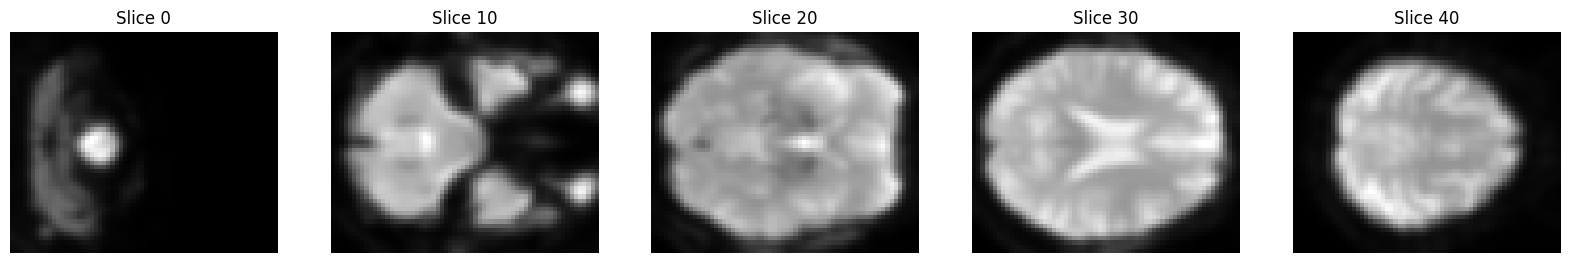

In [ ]:
# Select a specific time point
time_point = 0

# Create a figure with multiple subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Display multiple slices
for i, ax in enumerate(axes):
    slice_index = i * 10  # Adjust to choose slices
    ax.imshow(fmri_data1[:, :, slice_index, time_point], cmap='gray')
    ax.set_title(f'Slice {slice_index}')
    ax.axis('off')

plt.show()

In [ ]:
# Filter out subjects with excessive motion or insufficient unscrubbed volumes
filtered_metadata = metadata[(metadata['FD'] <= 0.5) & (metadata['sz'] != -1)]
print(f"Filtered subjects: {len(filtered_metadata)}")

Filtered subjects: 145


Additional libraries

In [ ]:
pip install Nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 99.8 MB/s eta 0:00:00


In [ ]:
from sklearn.utils import class_weight

In [ ]:
import nilearn

Further Preprocessing

In [ ]:
# Calculate class weights to address imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(metadata['sz']),
    y=metadata['sz']
)

class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Class weights: {class_weights}")

Class weights: {0: 0.9864864864864865, 1: 1.0138888888888888}


In [ ]:
def augment_data(fmri_data):
    # Example augmentation: flip along the x-axis
    augmented_data = np.flip(fmri_data, axis=0)
    return augmented_data

# Apply augmentation to each subject's data
data_df['nifti_data_augmented'] = data_df['nifti_data'].apply(augment_data)

In [ ]:
# Create a list to store the shapes of each subject's fMRI data
fmri_shapes = []

# Iterate through each subject's data in your DataFrame
for idx, row in data_df.iterrows():
    nifti_data = row['nifti_data']

    # Get the shape of the current subject's fMRI data
    shape = nifti_data.shape

    # Store the shape along with the subject ID
    fmri_shapes.append({
        'subject_id': row['subject_id'],
        'shape': shape,
        'remaining_frames': row['remaining_frames']
    })

# Convert the list to a DataFrame for easier inspection
shapes_df = pd.DataFrame(fmri_shapes)

# Display the first few entries
print(shapes_df.head())

# Check for unique shapes
unique_shapes = shapes_df['shape'].value_counts()
print(f"Unique shapes in the dataset:\n{unique_shapes}")

     subject_id              shape  remaining_frames
0  szxxx0040000  (53, 64, 52, 146)               146
1  szxxx0040001   (53, 64, 52, 40)                40
2  szxxx0040002   (53, 64, 52, 83)                83
3  szxxx0040003  (53, 64, 52, 120)               120
4  szxxx0040004  (53, 64, 52, 133)               133
Unique shapes in the dataset:
shape
(53, 64, 52, 40)     34
(53, 64, 52, 150)    10
(53, 64, 52, 146)     7
(53, 64, 52, 124)     4
(53, 64, 52, 142)     4
(53, 64, 52, 145)     4
(53, 64, 52, 82)      3
(53, 64, 52, 98)      3
(53, 64, 52, 129)     3
(53, 64, 52, 134)     3
(53, 64, 52, 83)      3
(53, 64, 52, 91)      2
(53, 64, 52, 128)     2
(53, 64, 52, 138)     2
(53, 64, 52, 135)     2
(53, 64, 52, 125)     2
(53, 64, 52, 111)     2
(53, 64, 52, 53)      2
(53, 64, 52, 122)     2
(53, 64, 52, 126)     2
(53, 64, 52, 45)      2
(53, 64, 52, 59)      2
(53, 64, 52, 108)     2
(53, 64, 52, 140)     2
(53, 64, 52, 133)     2
(53, 64, 52, 131)     2
(53, 64, 52, 119)     

Padding in Batches using Data Generator

In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence

# Custom padding function to pad along spatial and temporal dimensions
def custom_pad_fmri_data(fmri_data, target_shape):
    # Extract target dimensions
    target_depth, target_height, target_width, target_time = target_shape

    # Get current shape
    current_depth, current_height, current_width, current_time = fmri_data.shape

    # Pad depth, height, width, and time as necessary
    depth_pad = (0, target_depth - current_depth) if current_depth < target_depth else (0, 0)
    height_pad = (0, target_height - current_height) if current_height < target_height else (0, 0)
    width_pad = (0, target_width - current_width) if current_width < target_width else (0, 0)
    time_pad = (0, target_time - current_time) if current_time < target_time else (0, 0)

    # Apply padding using np.pad
    padded_data = np.pad(fmri_data, (depth_pad, height_pad, width_pad, time_pad), mode='constant', constant_values=0)

    return padded_data

# Define the custom data generator
class FMRIDataGenerator(Sequence):
    def __init__(self, data_df, batch_size, target_shape, shuffle=True):
        self.data_df = data_df
        self.batch_size = batch_size
        self.target_shape = target_shape  # target_shape should be (depth, height, width, time)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.data_df) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch, y_batch = self.__data_generation(indexes)
        return X_batch, y_batch

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data_df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        # Generate data for the current batch
        X_batch = [self.data_df.iloc[i]['nifti_data'] for i in indexes]
        y_batch = np.array([self.data_df.iloc[i]['metadata']['sz'] for i in indexes])

        # Pad each subject's fMRI data along spatial and temporal axes
        X_batch_padded = [custom_pad_fmri_data(data, self.target_shape) for data in X_batch]

        # Add a new dimension to fit the CNN input (batch, depth, height, width, time, channels)
        X_batch_padded = np.expand_dims(X_batch_padded, axis=-1)

        return np.array(X_batch_padded), y_batch

# Define the target shape (depth, height, width, time) based on the largest sample
target_shape = (53, 64, 52, 150)

# Initialize the data generator with custom padding in batches
batch_size = 8
training_generator = FMRIDataGenerator(data_df, batch_size=batch_size, target_shape=target_shape)

# Example: View the first batch
X_batch, y_batch = training_generator[0]
print(f"Shape of X_batch: {X_batch.shape}")


Shape of X_batch: (8, 53, 64, 52, 150, 1)


Loading ATLAS and Extraction of Time Series

In [ ]:
from nilearn import datasets
# Load AAL atlas
atlas_dataset = datasets.fetch_atlas_aal()
atlas_img = atlas_dataset.maps
labels = atlas_dataset.labels


Added README.md to /root/nilearn_data


Dataset created in /root/nilearn_data/aal_SPM12



 ...done. (1 seconds, 0 min)
Extracting data from /root/nilearn_data/aal_SPM12/a4f2a6316ec7f29f771edef840308edf/aal_for_SPM12.tar.gz..... done.


In [ ]:
from nilearn.input_data import NiftiLabelsMasker
# Create a masker object that will extract the time series from ROIs
masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=True)

In [ ]:
fmri_directory = '/content/drive/MyDrive/Datasets/FMRI/'
metadata_file = os.path.join(fmri_directory, 'cobre_group.csv')
metadata = pd.read_csv(metadata_file)

In [ ]:
# Create a dictionary to store time series for each subject
all_time_series = {}

In [ ]:
# Define batch size for processing
batch_size = 10  # Adjust based on memory constraints

# Function to process a batch of subjects
def process_batch(batch_metadata):
    batch_results = {}

    for idx, row in batch_metadata.iterrows():
        subject_id = row['subject_id']

        # Construct the file path for the subject's fMRI data
        fmri_file = os.path.join(fmri_directory, f'fmri_{subject_id}_session1_run1.nii.gz')

        # Check if the fMRI file exists
        if os.path.exists(fmri_file):
            # Load the fMRI data for the subject
            fmri_img = nib.load(fmri_file)

            # Extract time series for ROIs
            time_series = masker.fit_transform(fmri_img)

            # Store the time series in the batch results
            batch_results[subject_id] = time_series

            # Optional: Print progress
            print(f"Extracted time series for subject {subject_id}, shape: {time_series.shape}")
        else:
            print(f"fMRI file not found for subject {subject_id}")

    # Clean up memory
    gc.collect()

    return batch_results

# Process data in batches
total_subjects = len(metadata)
for start_idx in range(0, total_subjects, batch_size):
    end_idx = min(start_idx + batch_size, total_subjects)
    print(f'Processing batch {start_idx + 1} to {end_idx}')

    # Select the current batch of metadata
    batch_metadata = metadata.iloc[start_idx:end_idx]

    # Process the current batch
    batch_results = process_batch(batch_metadata)

    # Append batch results to the overall dictionary
    all_time_series.update(batch_results)

    # Clean up memory
    gc.collect()

# Option 1: Save time series as individual files for each subject
output_directory = '/content/drive/MyDrive/Datasets/FMRI/time_series/'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

for subject_id, time_series in all_time_series.items():
    np.save(os.path.join(output_directory, f'time_series_{subject_id}.npy'), time_series)

# Option 2: Save all time series in one .npy file (not recommended for large data)
np.save('all_time_series.npy', all_time_series)

# Check the extracted time series data
print(f"Time series saved for {len(all_time_series)} subjects.")


Processing batch 1 to 10
Extracted time series for subject szxxx0040000, shape: (146, 116)
Extracted time series for subject szxxx0040001, shape: (40, 116)
Extracted time series for subject szxxx0040002, shape: (83, 116)
Extracted time series for subject szxxx0040003, shape: (120, 116)
Extracted time series for subject szxxx0040004, shape: (133, 116)
Extracted time series for subject szxxx0040005, shape: (40, 116)
Extracted time series for subject szxxx0040006, shape: (89, 116)
Extracted time series for subject szxxx0040007, shape: (40, 116)
Extracted time series for subject szxxx0040008, shape: (131, 116)
Extracted time series for subject szxxx0040009, shape: (40, 116)
Processing batch 11 to 20
Extracted time series for subject szxxx0040010, shape: (119, 116)
Extracted time series for subject szxxx0040011, shape: (40, 116)
Extracted time series for subject szxxx0040012, shape: (46, 116)
Extracted time series for subject szxxx0040015, shape: (40, 116)
Extracted time series for subject 

Pearson Correlation

In [ ]:
def compute_connectivity_matrix(time_series):
    # Compute the correlation matrix for the time series
    correlation_matrix = np.corrcoef(time_series.T)
    return correlation_matrix

In [ ]:
# Create a dictionary to store the connectivity matrices for each subject
all_connectivity_matrices = {}

# Loop through each subject's time series and compute the connectivity matrix
for subject_id, time_series in all_time_series.items():
    # Compute the connectivity matrix
    connectivity_matrix = compute_connectivity_matrix(time_series)

    # Store the connectivity matrix in the dictionary
    all_connectivity_matrices[subject_id] = connectivity_matrix

In [ ]:
# Example: Check a sample connectivity matrix
subject_id_sample = list(all_connectivity_matrices.keys())[0]
print(f"Sample connectivity matrix for subject {subject_id_sample}:")
print(all_connectivity_matrices[subject_id_sample])

Sample connectivity matrix for subject szxxx0040000:
[[1.         0.6542244  0.56203959 ... 0.30283889 0.14828785 0.03411433]
 [0.6542244  1.         0.65681226 ... 0.24765934 0.17436843 0.0372899 ]
 [0.56203959 0.65681226 1.         ... 0.36824753 0.37186928 0.1869821 ]
 ...
 [0.30283889 0.24765934 0.36824753 ... 1.         0.62706636 0.28718179]
 [0.14828785 0.17436843 0.37186928 ... 0.62706636 1.         0.43323978]
 [0.03411433 0.0372899  0.1869821  ... 0.28718179 0.43323978 1.        ]]


In [ ]:
# Loop through all connectivity matrices and print their shapes
for subject_id, matrix in all_connectivity_matrices.items():
    print(f"Shape of connectivity matrix for subject {subject_id}: {matrix.shape}")


Shape of connectivity matrix for subject szxxx0040000: (116, 116)
Shape of connectivity matrix for subject szxxx0040001: (116, 116)
Shape of connectivity matrix for subject szxxx0040002: (116, 116)
Shape of connectivity matrix for subject szxxx0040003: (116, 116)
Shape of connectivity matrix for subject szxxx0040004: (116, 116)
Shape of connectivity matrix for subject szxxx0040005: (116, 116)
Shape of connectivity matrix for subject szxxx0040006: (116, 116)
Shape of connectivity matrix for subject szxxx0040007: (116, 116)
Shape of connectivity matrix for subject szxxx0040008: (116, 116)
Shape of connectivity matrix for subject szxxx0040009: (116, 116)
Shape of connectivity matrix for subject szxxx0040010: (116, 116)
Shape of connectivity matrix for subject szxxx0040011: (116, 116)
Shape of connectivity matrix for subject szxxx0040012: (116, 116)
Shape of connectivity matrix for subject szxxx0040015: (116, 116)
Shape of connectivity matrix for subject szxxx0040016: (116, 116)
Shape of c

In [ ]:
# Reshape each matrix to (116, 116, 1)
for subject_id in all_connectivity_matrices:
    all_connectivity_matrices[subject_id] = all_connectivity_matrices[subject_id].reshape(116, 116, 1)

# Verify by printing one of the reshaped matrices
subject_id_sample = list(all_connectivity_matrices.keys())[0]
print(f"Shape after reshaping for subject {subject_id_sample}: {all_connectivity_matrices[subject_id_sample].shape}")

Shape after reshaping for subject szxxx0040000: (116, 116, 1)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence
# Custom Data Generator for Connectivity Matrices
class ConnectivityDataGenerator(Sequence):
    def __init__(self, time_series_data, labels, batch_size=8, shuffle=True):
        self.time_series_data = time_series_data  # Dictionary with time series data
        self.labels = labels  # Corresponding labels (0: control, 1: schizophrenia)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.labels))
        self.on_epoch_end()

    def __len__(self):
        return len(self.labels) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.labels))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X_batch = []
        y_batch = []
        for i in indexes:
            subject_id = list(self.time_series_data.keys())[i]
            time_series = self.time_series_data[subject_id]

            # Compute the connectivity matrix
            connectivity_matrix = compute_connectivity_matrix(time_series)

            # Resize the matrix to match input requirements of CNN
            connectivity_matrix = np.expand_dims(connectivity_matrix, axis=-1)  # Add channel dimension

            X_batch.append(connectivity_matrix)
            y_batch.append(self.labels[i])

        X_batch = np.array(X_batch)
        y_batch = np.array(y_batch)
        return X_batch, y_batch




Model Building

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence

# Function to compute Pearson correlation matrix (functional connectivity)
def compute_connectivity_matrix(time_series):
    correlation_matrix = np.corrcoef(time_series.T)  # Transpose to have ROIs in columns
    return correlation_matrix

# Custom Data Generator for Connectivity Matrices
class ConnectivityDataGenerator(Sequence):
    def __init__(self, time_series_data, labels, batch_size=8, shuffle=True):
        self.time_series_data = time_series_data  # Dictionary with time series data
        self.labels = labels  # Corresponding labels (0: control, 1: schizophrenia)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.labels))
        self.on_epoch_end()

    def __len__(self):
        return len(self.labels) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.labels))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X_batch = []
        y_batch = []
        for i in indexes:
            subject_id = list(self.time_series_data.keys())[i]
            time_series = self.time_series_data[subject_id]

            # Compute the connectivity matrix
            connectivity_matrix = compute_connectivity_matrix(time_series)

            # Resize the matrix to match input requirements of CNN
            connectivity_matrix = np.expand_dims(connectivity_matrix, axis=-1)  # Add channel dimension

            X_batch.append(connectivity_matrix)
            y_batch.append(self.labels[i])

        X_batch = np.array(X_batch)
        y_batch = np.array(y_batch)
        return X_batch, y_batch

# Build 2D CNN + LSTM Model
def build_cnn_lstm(input_shape):
    model = models.Sequential()

    # 2D Convolutional layers to capture spatial patterns
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten and pass to LSTM
    model.add(layers.TimeDistributed(layers.Flatten()))

    # LSTM layer to capture temporal dependencies
    model.add(layers.LSTM(128, return_sequences=False))

    # Fully connected layers
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output layer for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Example Input Shape
input_shape = (116, 116, 1)  # Adjust based on your connectivity matrix size (e.g., 116 ROIs)

# Build and compile the model
model = build_cnn_lstm(input_shape)
model.summary()

# Assuming you have extracted time series and have corresponding labels
# Example: labels = [0, 1, 1, 0, 1] where 0 = healthy control, 1 = schizophrenia

# Split the data into training and validation sets
labels = metadata['sz'].values  # Assuming 'sz' column contains labels (0 or 1)
X_train, X_val, y_train, y_val = train_test_split(list(all_time_series.keys()), labels, test_size=0.2, random_state=42)

# Initialize the data generators
train_generator = ConnectivityDataGenerator({k: all_time_series[k] for k in X_train}, y_train, batch_size=8)
val_generator = ConnectivityDataGenerator({k: all_time_series[k] for k in X_val}, y_val, batch_size=8)

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=25)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 114, 114, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 57, 57, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 55, 55, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 12, 1536)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         852,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 953,473 (3.64 MB)

 Trainable params: 953,473 (3.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4920 - loss: 0.7140

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.4974 - loss: 0.7128 - val_accuracy: 0.6250 - val_loss: 0.6895
Epoch 2/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5759 - loss: 0.6753 - val_accuracy: 0.4167 - val_loss: 0.7421
Epoch 3/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6004 - loss: 0.6637 - val_accuracy: 0.4167 - val_loss: 0.7333
Epoch 4/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6350 - loss: 0.6587 - val_accuracy: 0.6250 - val_loss: 0.7056
Epoch 5/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6786 - loss: 0.6472 - val_accuracy: 0.5417 - val_loss: 0.8295
Epoch 6/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5915 - loss: 0.6583 - val_accuracy: 0.5000 - val_loss: 0.8093
Epoch 7/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6538 - loss: 0.6159 - val_accuracy: 0.5417 - val_loss: 0.6895
Epoch 8/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7478 - loss: 0.5871 - val_accuracy: 0.5417 - val_loss: 0.

In [ ]:
from tensorflow.keras import layers, models, regularizers

def build_cnn_lstm(input_shape):
    model = models.Sequential()

    # 2D Convolutional layers to capture spatial patterns
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    # Flatten and pass to LSTM
    model.add(layers.TimeDistributed(layers.Flatten()))

    # LSTM layer
    model.add(layers.LSTM(64, return_sequences=False))
    model.add(layers.Dropout(0.5))

    # Fully connected layers
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))

    # Output layer for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate scheduler to reduce learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

In [ ]:
# Build and compile the model
model = build_cnn_lstm(input_shape)
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 114, 114, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 57, 57, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 57, 57, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 57, 57, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 55, 55, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 27, 27, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 27, 1728)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 64)                  │         459,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 482,433 (1.84 MB)

 Trainable params: 482,241 (1.84 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# Fit the model using class weights
history = model2.fit(train_generator, validation_data=val_generator, epochs=100, class_weight=class_weights, callbacks=[early_stopping, lr_scheduler])


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.4548 - loss: 0.8943 - val_accuracy: 0.3750 - val_loss: 0.8398 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6628 - loss: 0.8526 - val_accuracy: 0.4583 - val_loss: 0.9165 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6814 - loss: 0.7401 - val_accuracy: 0.4583 - val_loss: 0.9514 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5926 - loss: 0.7512 - val_accuracy: 0.4583 - val_loss: 0.8705 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6198 - loss: 0.7574 - val_accuracy: 0.4167 - val_loss: 0.8770 - learning_rate: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7255 - loss: 0.6482 - val_accuracy: 0.4167 - val_loss: 0.9611 - learning_rate: 0.0010


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'all_time_series' contains time series for all subjects
# Assuming 'labels' is a list or array of labels (0 = healthy, 1 = schizophrenia)

# Create a list of subject IDs
subject_ids = list(all_time_series.keys())
labels = metadata['sz'].values  # Extract labels from metadata (sz column)

# Split the data into train, validation, and test sets (70% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(subject_ids, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}, Validation set size: {len(X_val)}, Test set size: {len(X_test)}")


Training set size: 102, Validation set size: 22, Test set size: 22


In [ ]:
test_generator = ConnectivityDataGenerator({k: all_time_series[k] for k in X_test}, y_test, batch_size=8)


In [ ]:
# Assuming `all_time_series` is a dictionary and `X_test` is a list of test subject IDs
test_subjects = X_test
test_labels = y_test  # Corresponding labels for the test set

# Create the test data generator
test_generator = ConnectivityDataGenerator(
    time_series_data={k: all_time_series[k] for k in test_subjects},
    labels=test_labels,
    batch_size=8
)

# Generate predictions
y_pred = model2.predict(test_generator)

# Convert probabilities to binary labels
y_pred_labels = (y_pred > 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize empty lists to gather all test labels and predictions
y_pred_labels = []
y_true = []
y_pred_probs = []  # To store predicted probabilities for AUC

# Iterate over the test generator and collect predictions and true labels
for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]  # Get the batch from the test generator
    y_true.extend(y_batch)  # Append true labels
    y_pred = model.predict(X_batch)  # Get predictions for the batch
    y_pred_probs.extend(y_pred)  # Save probabilities for AUC calculation
    y_pred_labels.extend((y_pred > 0.5).astype(int))  # Convert to binary labels and append

# Convert lists to numpy arrays
y_pred_labels = np.array(y_pred_labels).flatten()
y_pred_probs = np.array(y_pred_probs).flatten()  # For AUC
y_true = np.array(y_true)

# Check lengths of y_true and y_pred_labels
print(f"Length of y_true: {len(y_true)}, Length of y_pred_labels: {len(y_pred_labels)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Length of y_true: 16, Length of y_pred_labels: 16


In [ ]:
# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_labels, target_names=['Healthy Control', 'Schizophrenia']))

Test Accuracy: 0.8750
Classification Report:
                 precision    recall  f1-score   support

Healthy Control       0.71      1.00      0.83         5
  Schizophrenia       1.00      0.82      0.90        11

       accuracy                           0.88        16
      macro avg       0.86      0.91      0.87        16
   weighted avg       0.91      0.88      0.88        16



Confusion Matrix:
[[5 0]
 [2 9]]


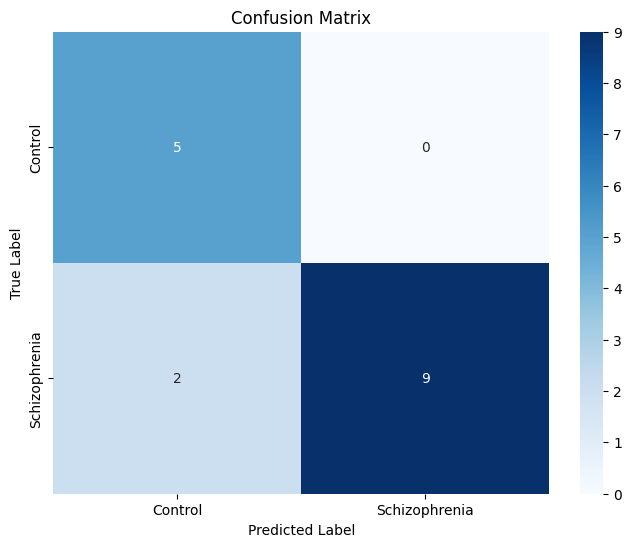

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Schizophrenia'], yticklabels=['Control', 'Schizophrenia'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


AUC-ROC: 0.9818


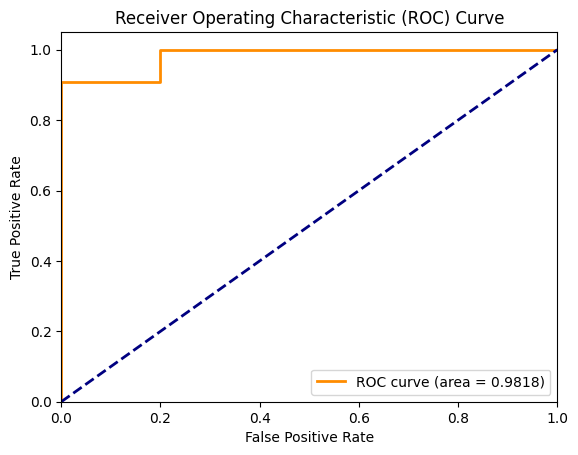

In [ ]:
# Calculate AUC-ROC
auc_roc = roc_auc_score(y_true, y_pred_probs)
print(f"AUC-ROC: {auc_roc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Saliency Maps

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming `all_connectivity_matrices` contains the functional connectivity matrices for each subject
# And your trained CNN-LSTM model is named `model`

# Function to compute saliency map for a given subject's connectivity matrix
def compute_saliency_map(model, connectivity_matrix_tensor, target_class_idx=1):
    with tf.GradientTape() as tape:
        tape.watch(connectivity_matrix_tensor)
        predictions = model(connectivity_matrix_tensor)
        loss = predictions[:, target_class_idx]

    # Get the gradient of the loss w.r.t the input connectivity matrix
    saliency = tape.gradient(loss, connectivity_matrix_tensor)

    # Take the absolute value of the gradients to focus on magnitude
    saliency = tf.math.abs(saliency)

    # Reduce the saliency along the batch and channel dimensions
    saliency = tf.reduce_mean(saliency, axis=-1)

    return saliency.numpy()

# List to store saliency maps for all subjects
all_saliency_maps = []

# Loop through each subject and calculate the saliency map
for subject_id in list(all_connectivity_matrices.keys()):
    # Retrieve the connectivity matrix for the current subject
    connectivity_matrix = all_connectivity_matrices[subject_id]

    # Reshape the matrix to match the model's input shape (1, 116, 116, 1)
    connectivity_matrix = np.expand_dims(connectivity_matrix, axis=0)  # Add batch dimension
    connectivity_matrix = np.expand_dims(connectivity_matrix, axis=-1)  # Add channel dimension

    # Convert to tensor
    connectivity_matrix_tensor = tf.convert_to_tensor(connectivity_matrix, dtype=tf.float32)

    # Compute saliency map for the target class (e.g., schizophrenia)
    saliency_map = compute_saliency_map(model, connectivity_matrix_tensor, target_class_idx=0)

    # Store the saliency map
    all_saliency_maps.append(saliency_map[0, :, :])  # Remove the batch dimension


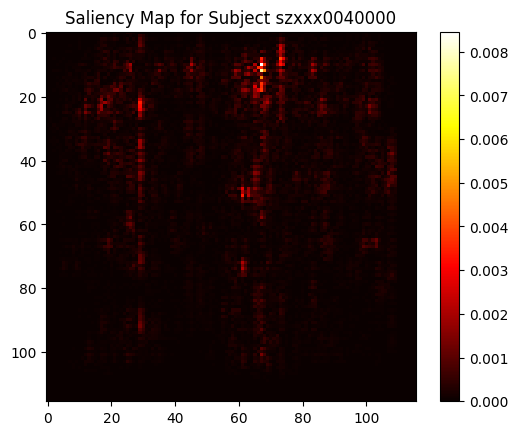

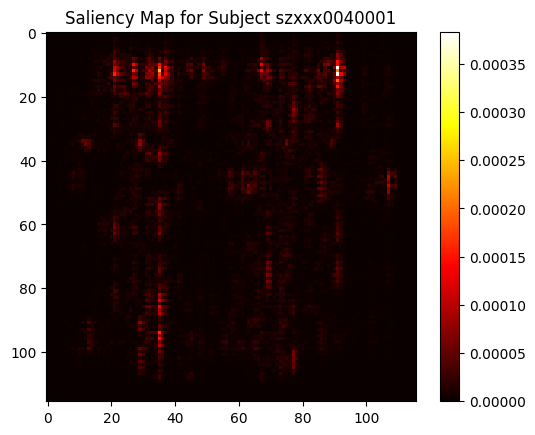

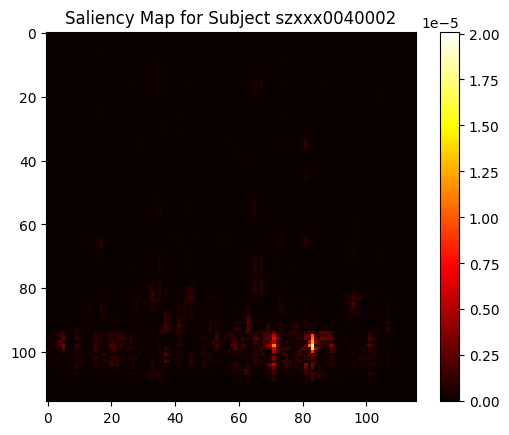

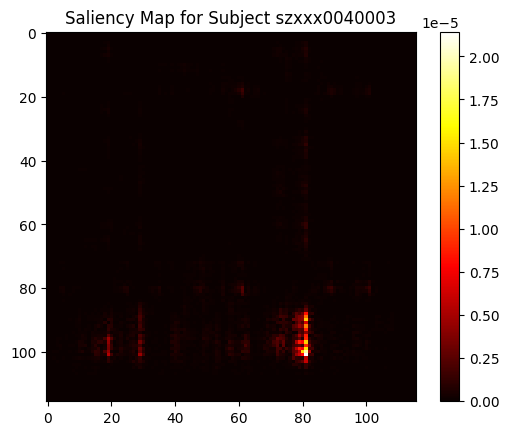

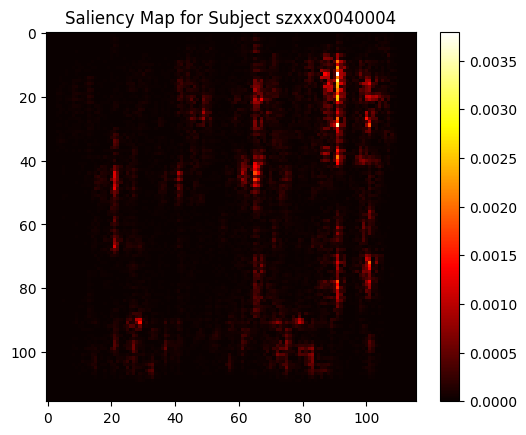

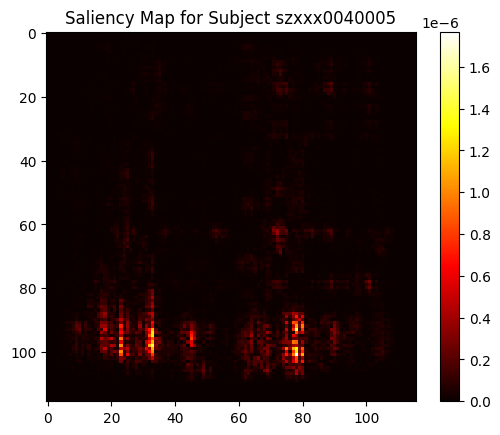

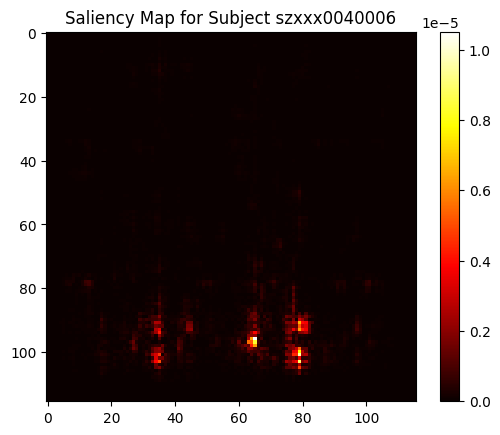

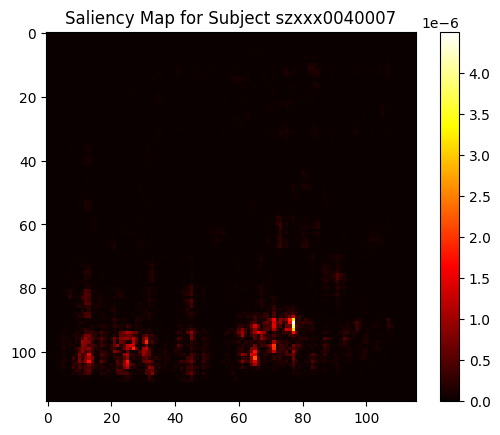

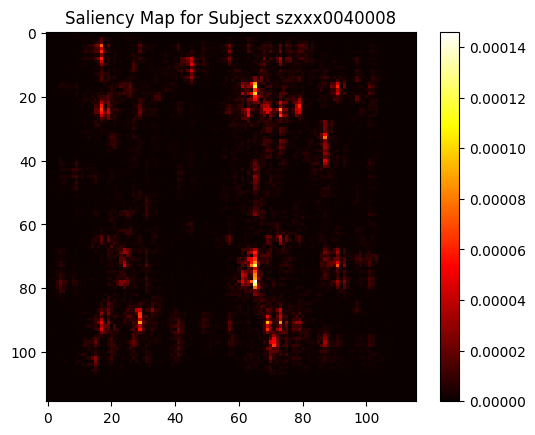

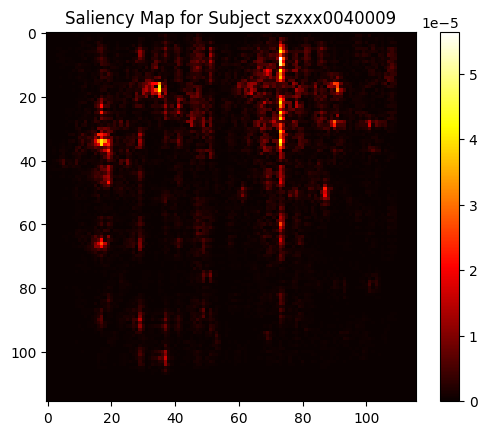

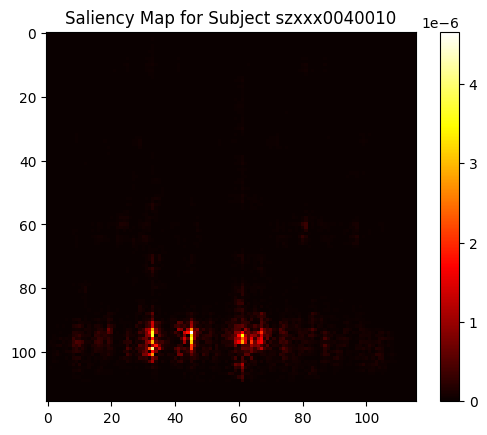

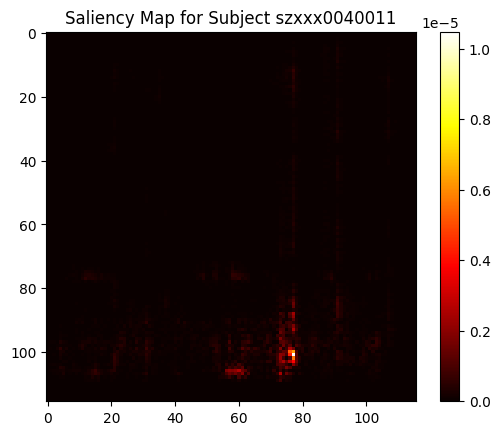

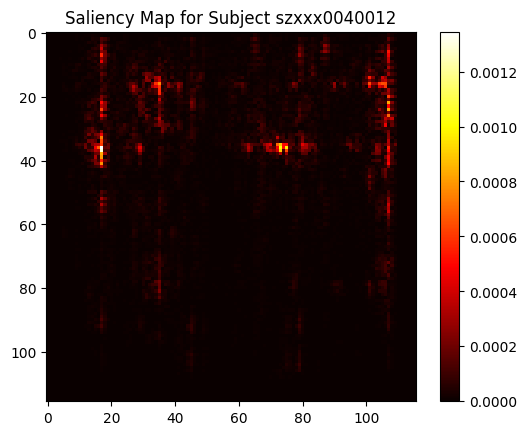

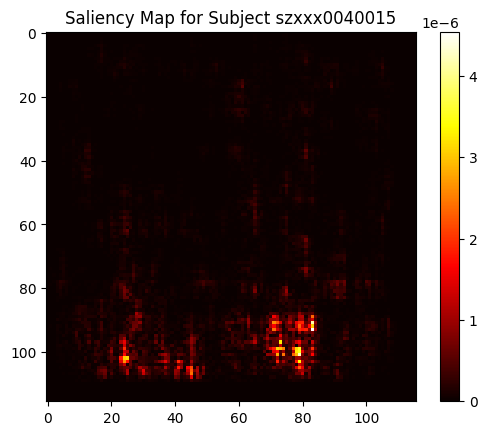

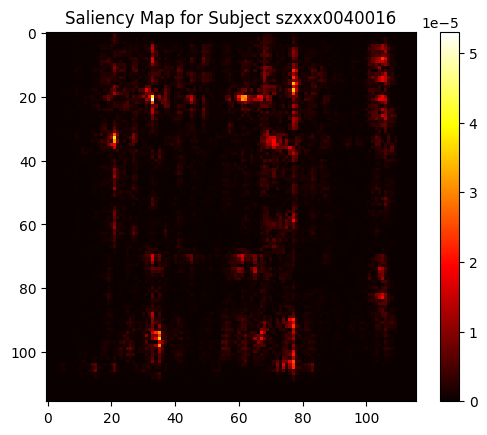

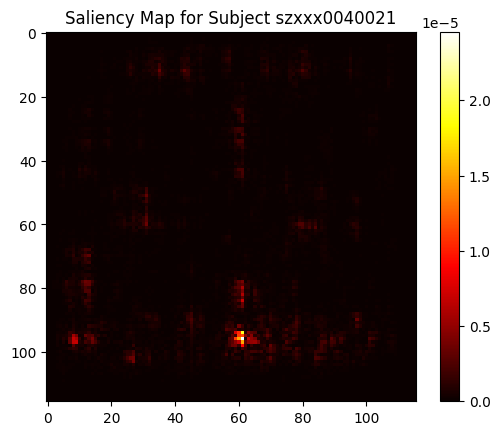

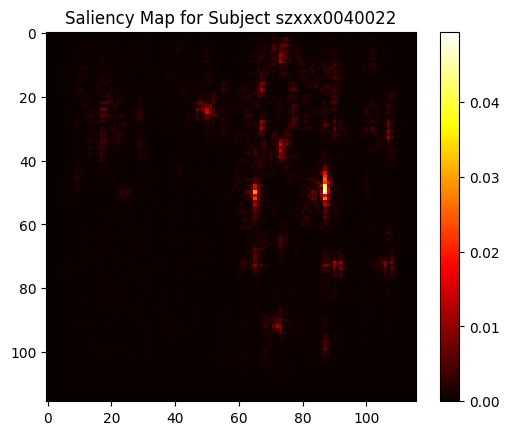

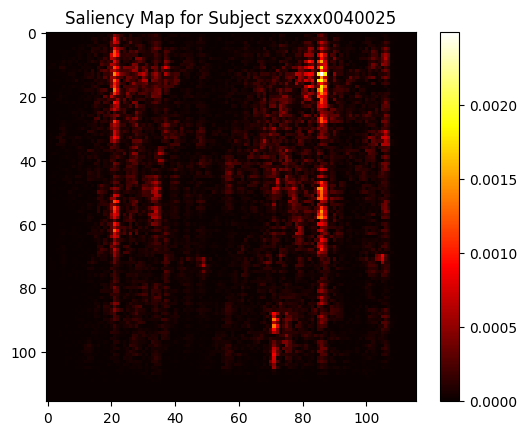

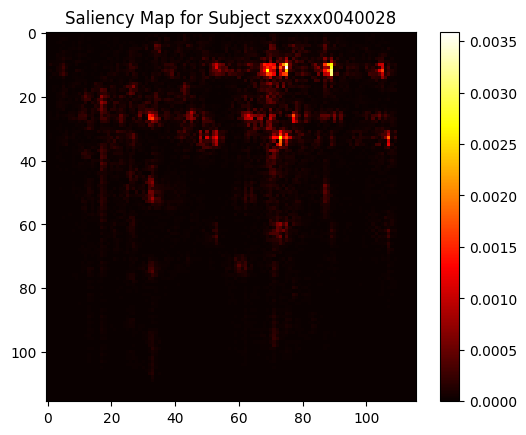

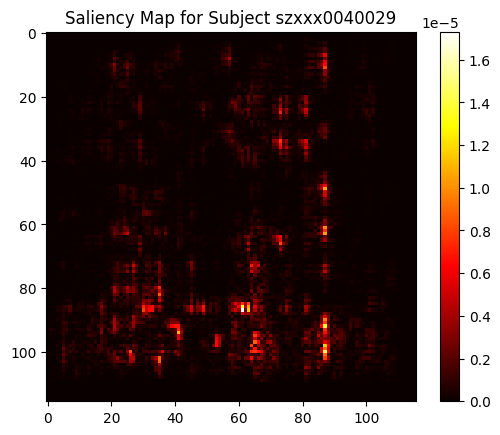

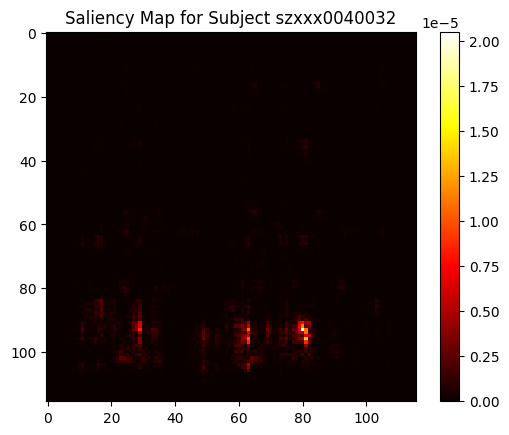

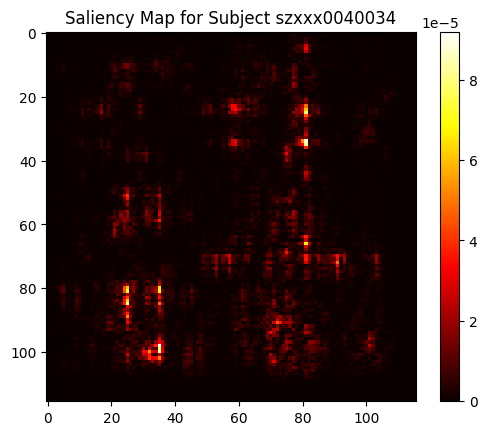

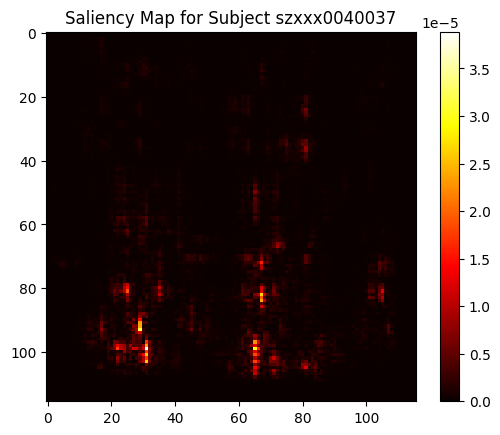

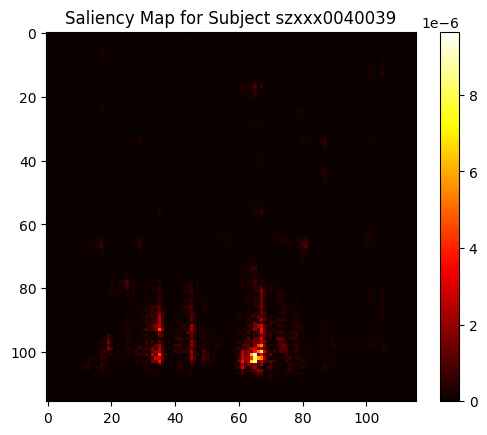

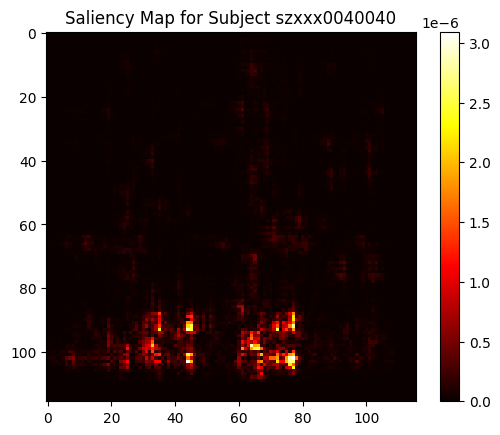

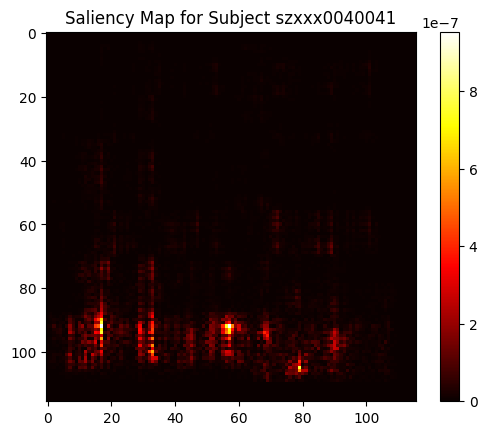

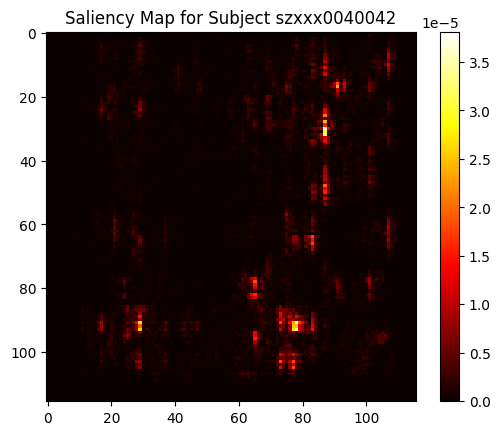

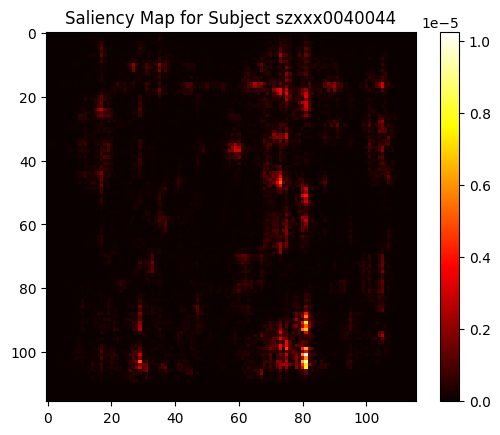

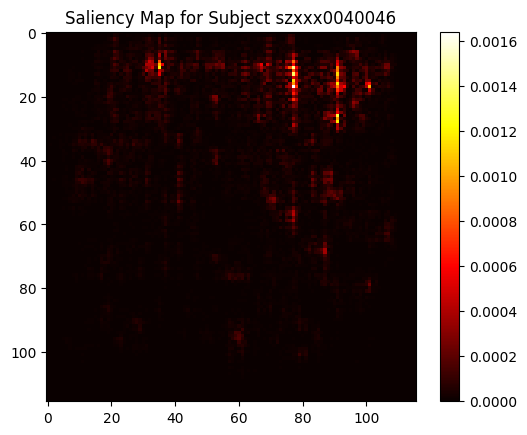

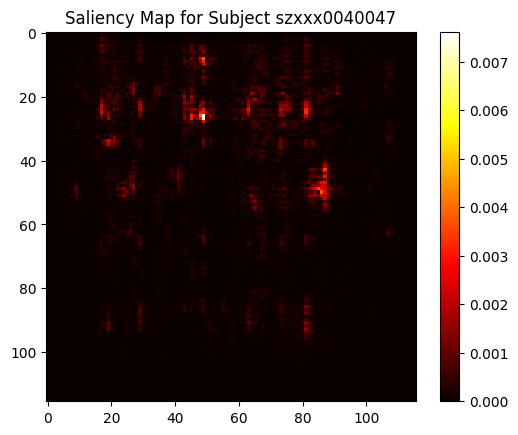

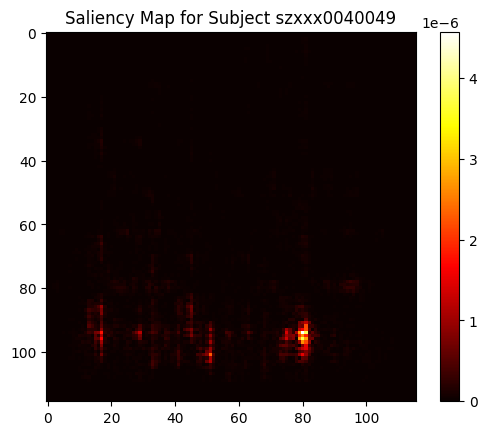

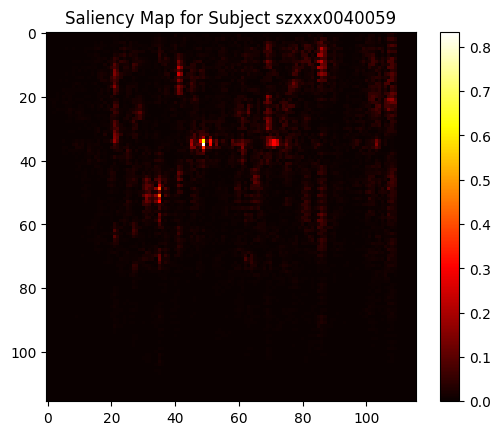

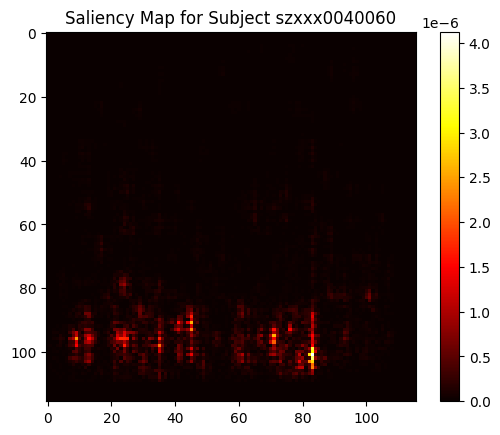

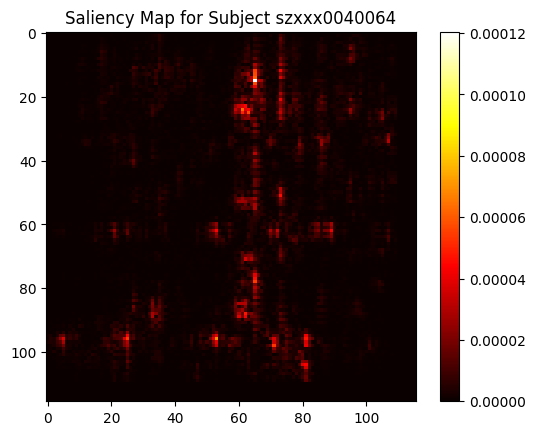

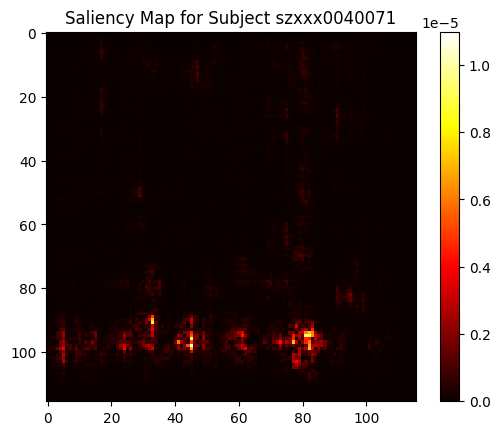

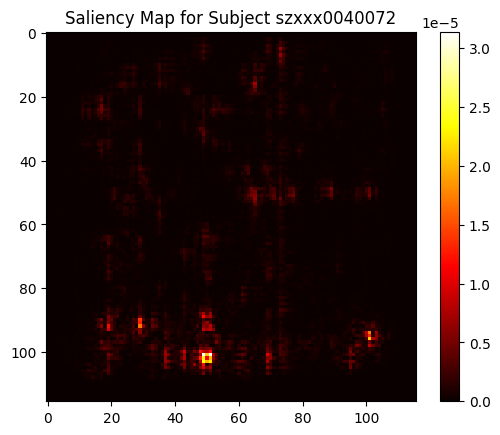

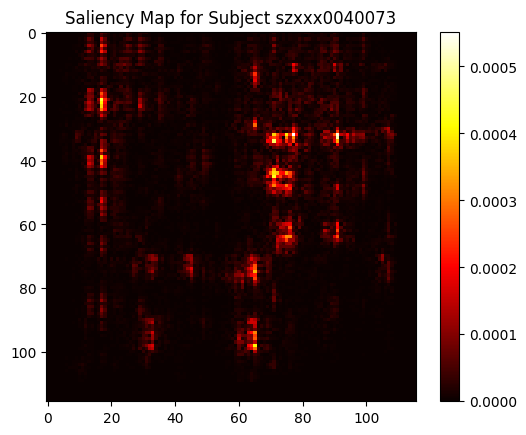

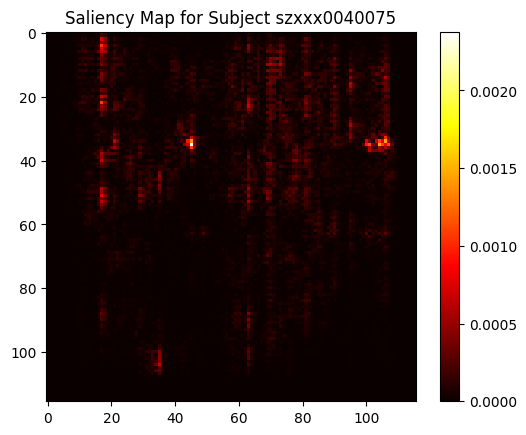

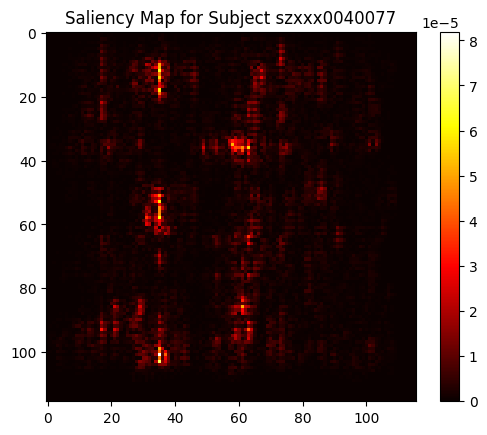

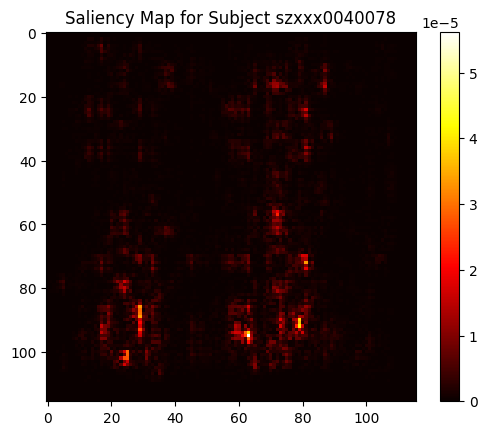

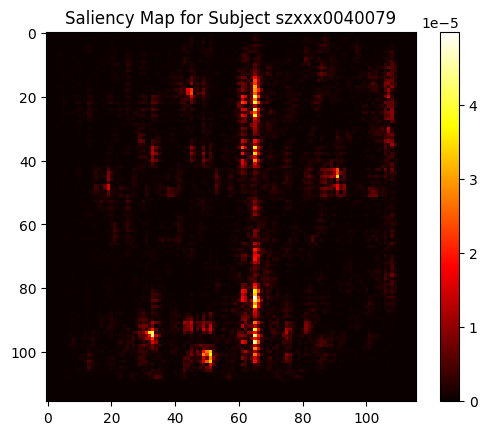

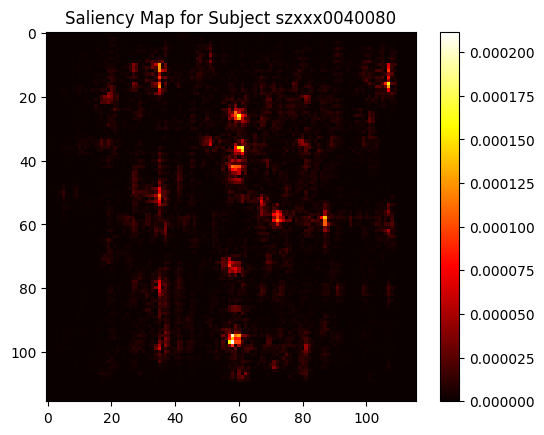

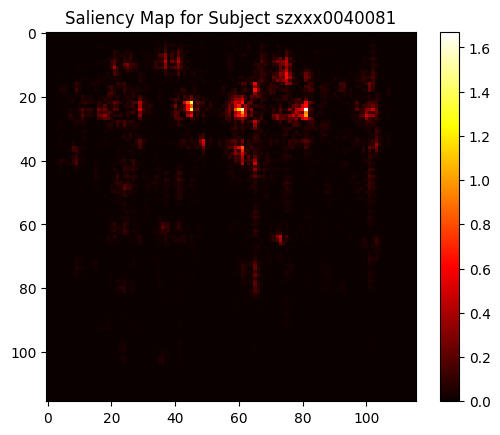

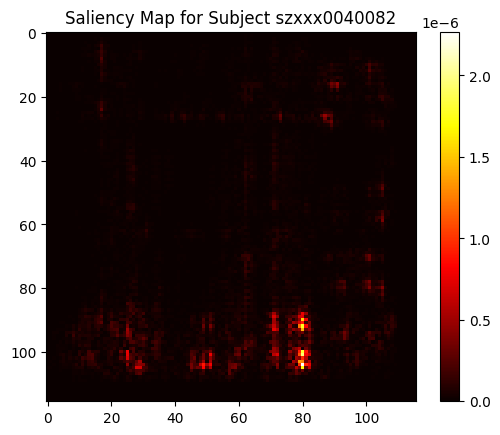

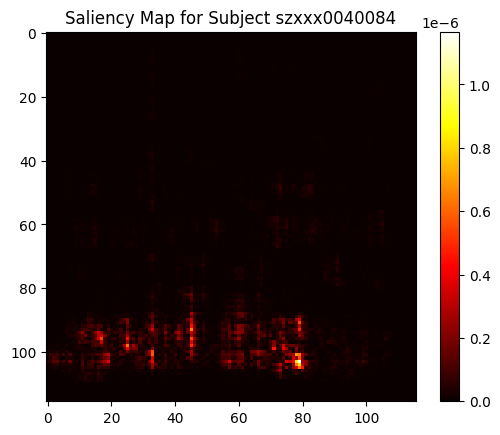

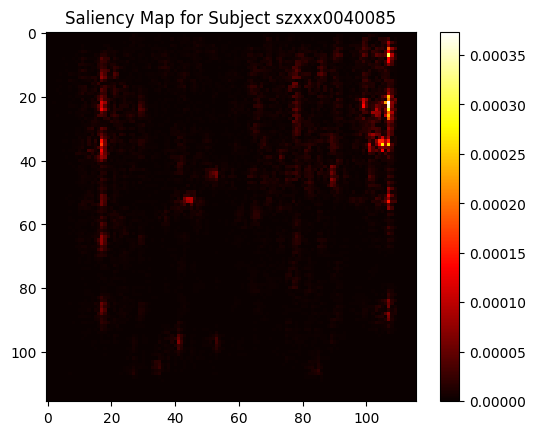

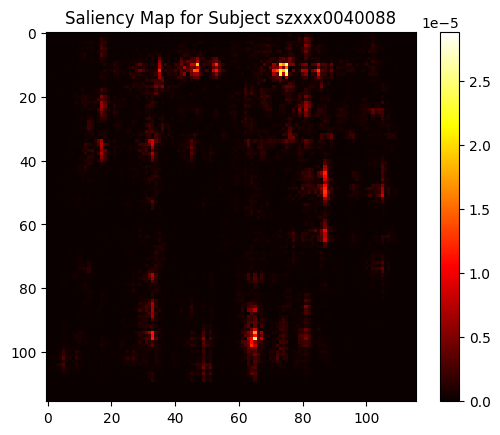

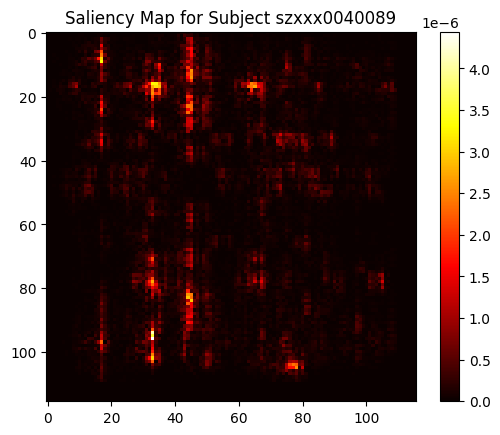

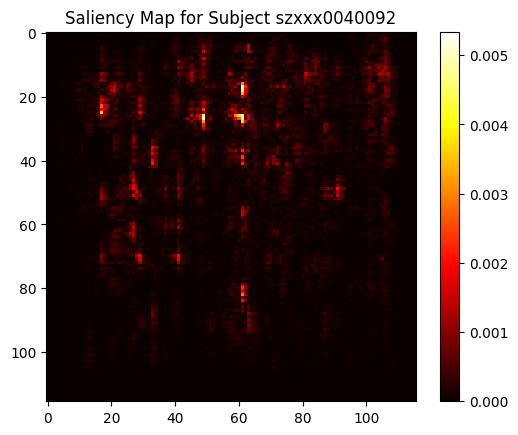

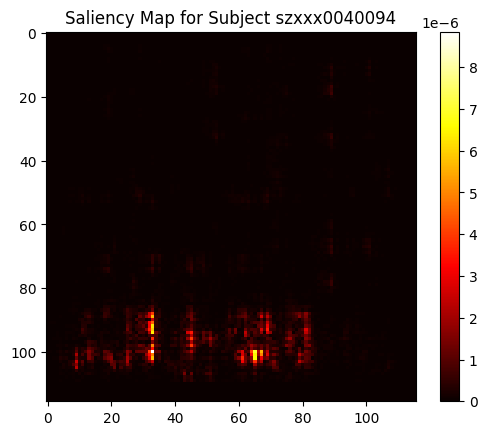

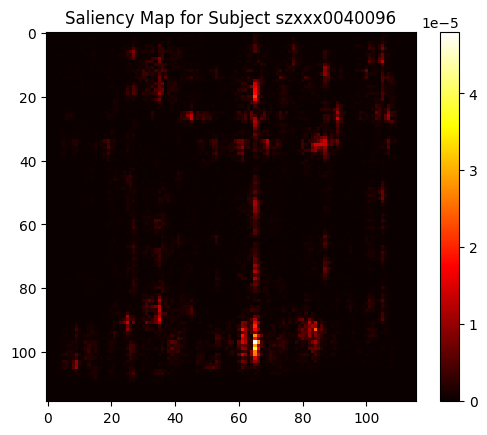

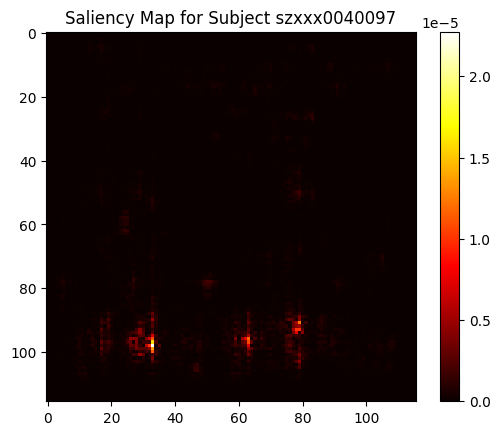

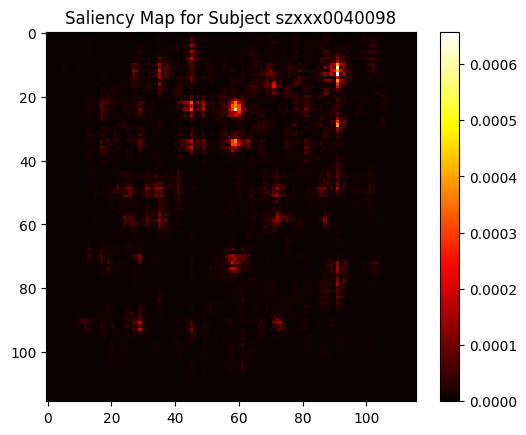

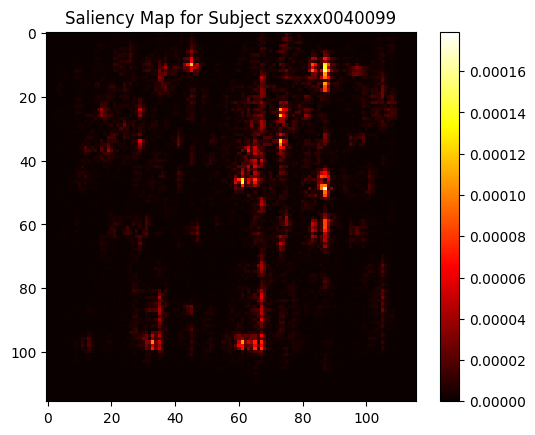

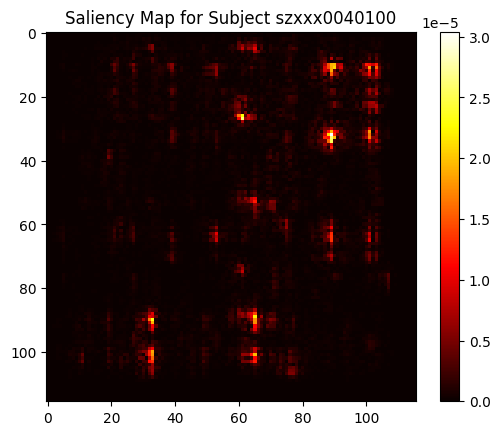

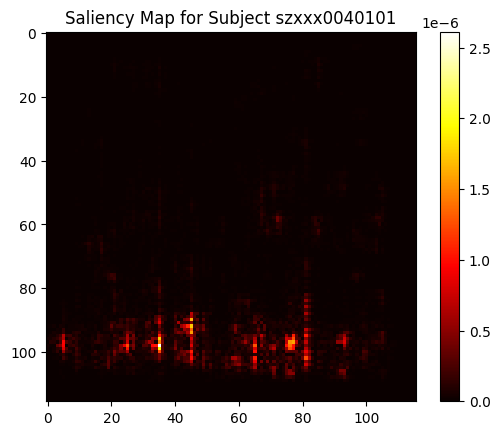

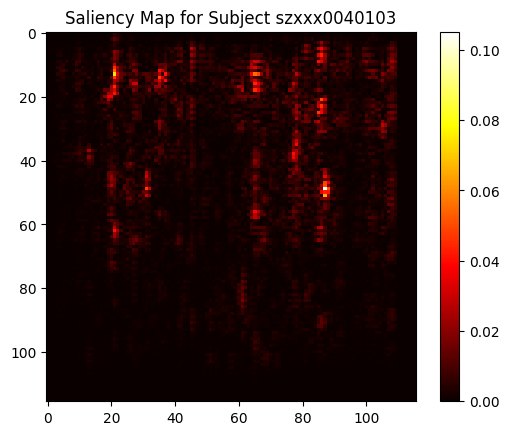

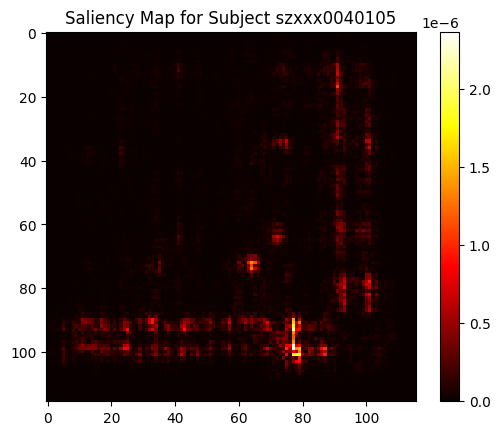

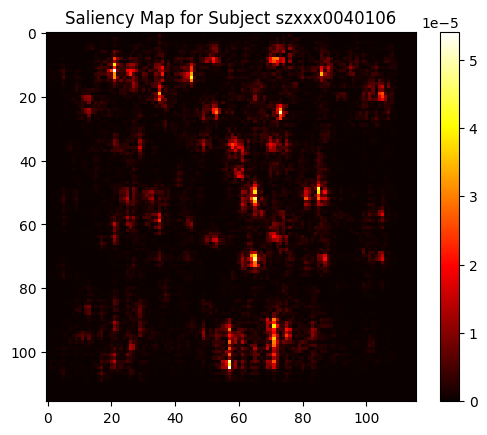

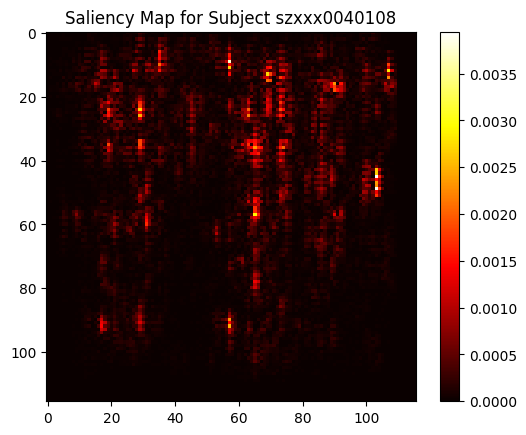

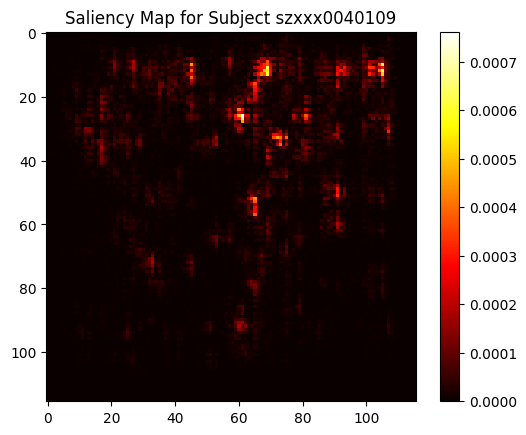

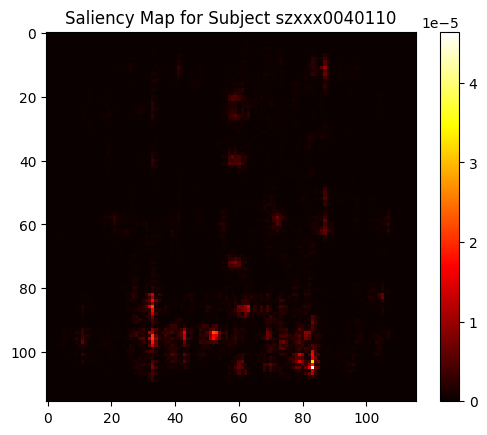

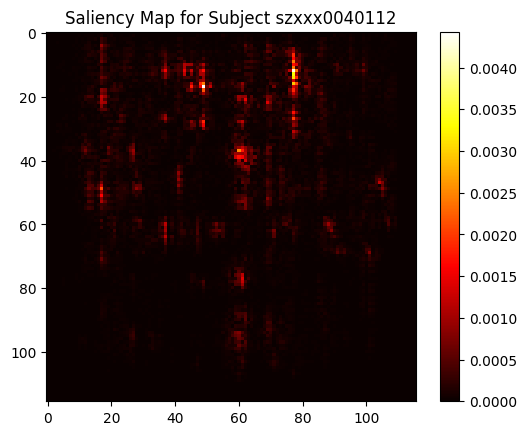

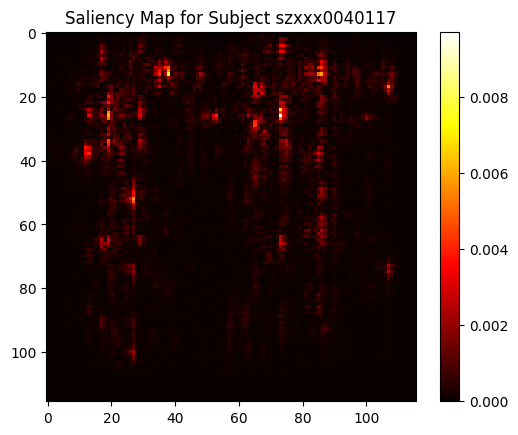

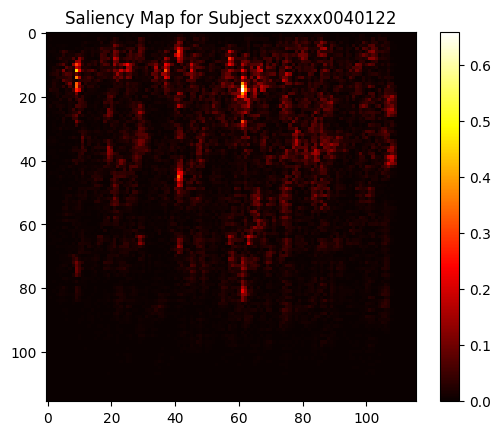

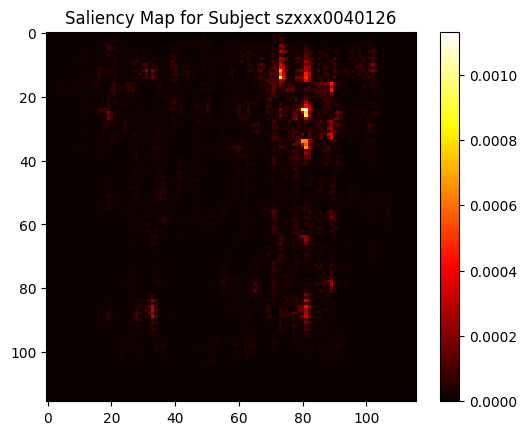

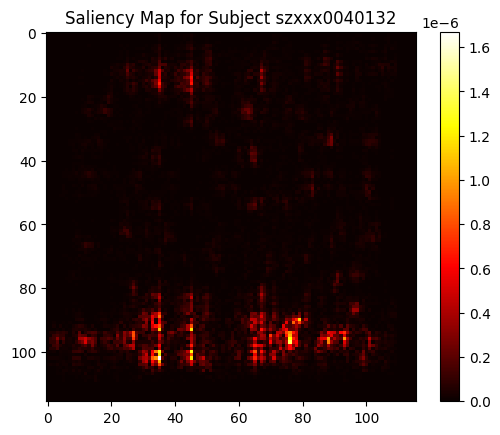

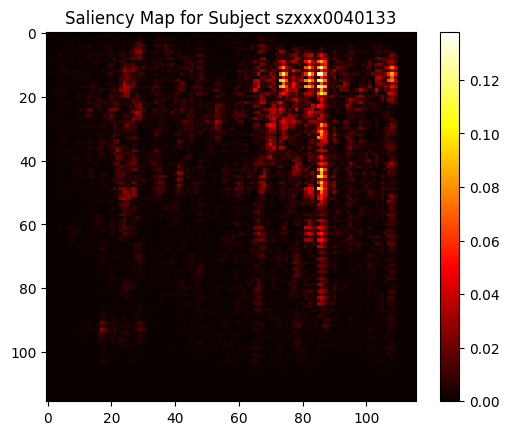

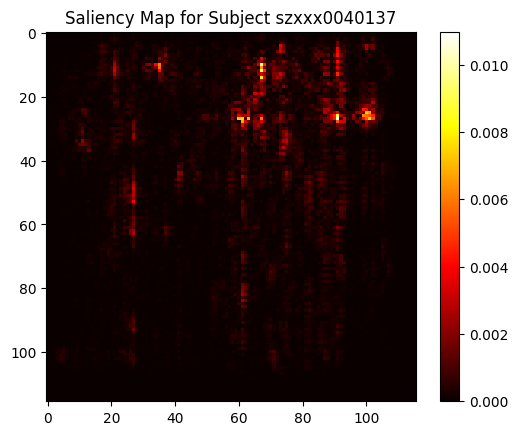

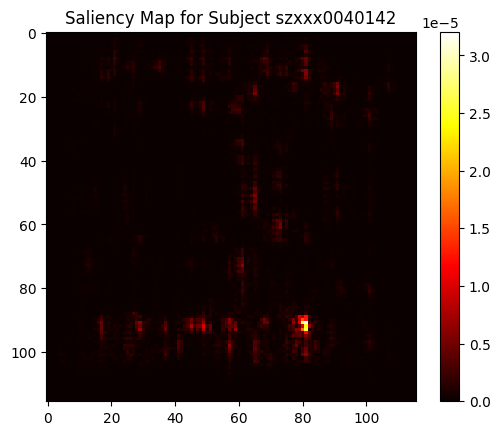

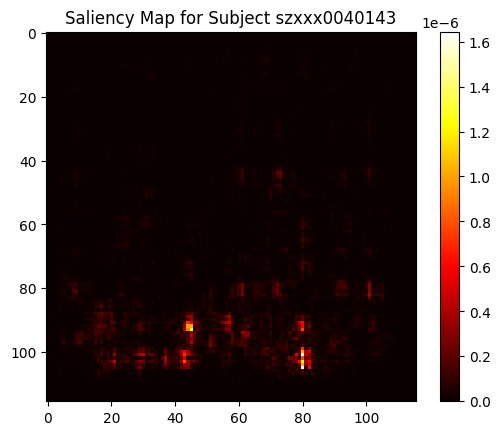

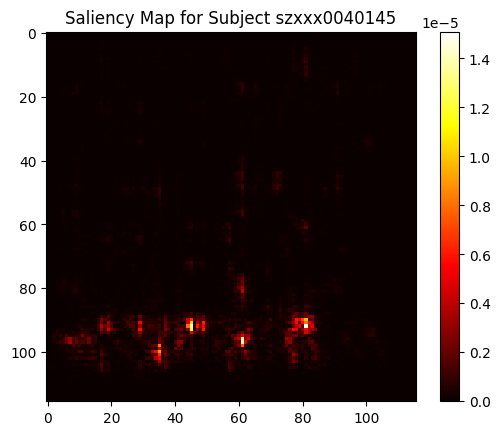

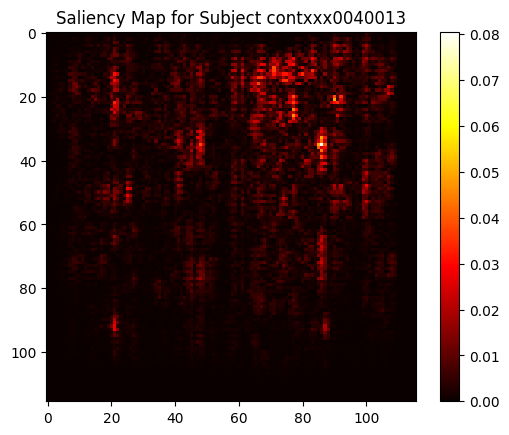

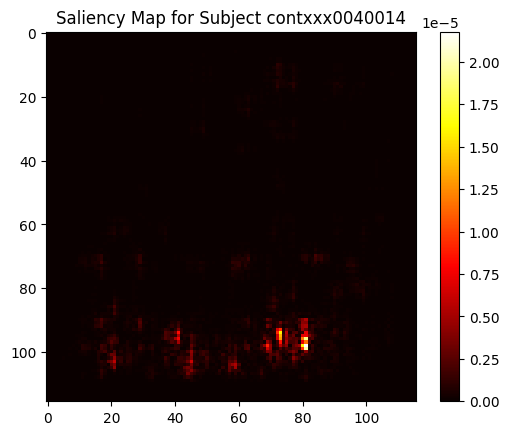

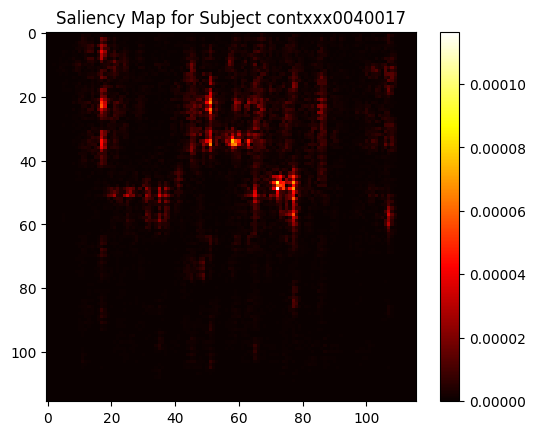

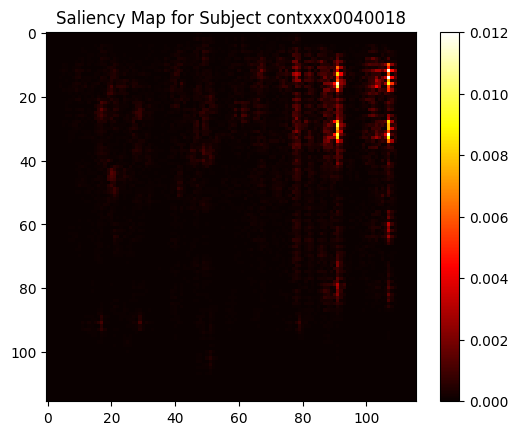

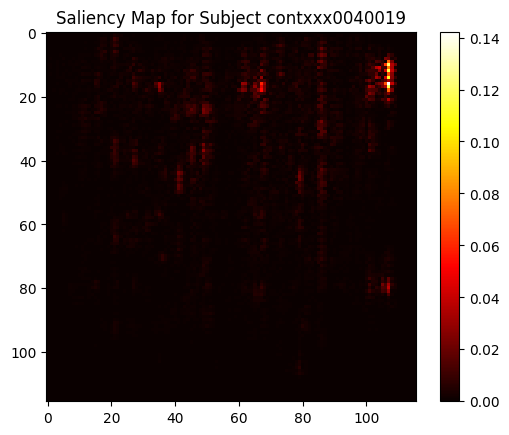

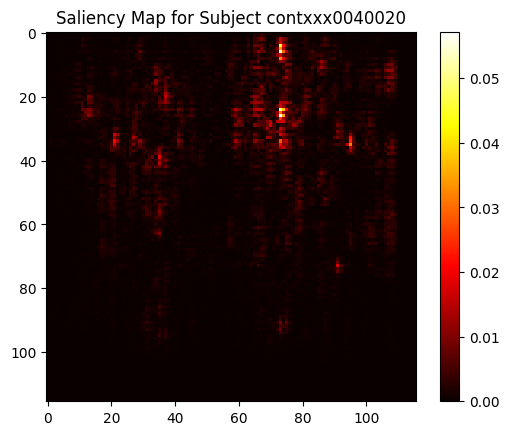

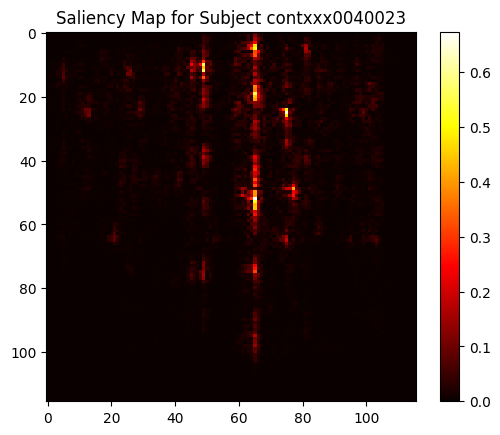

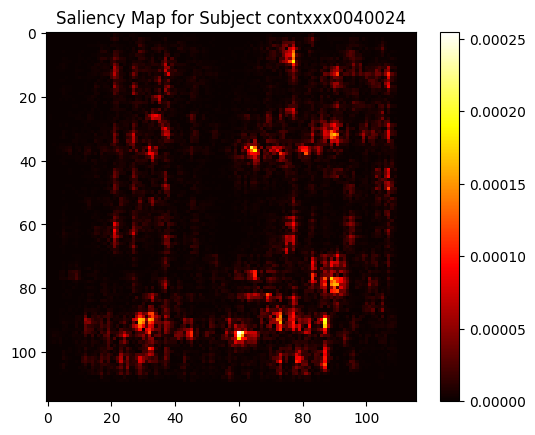

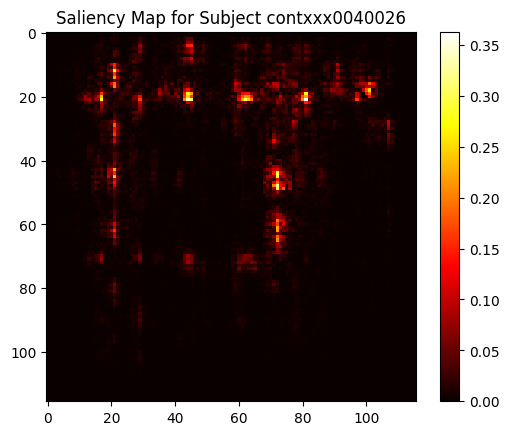

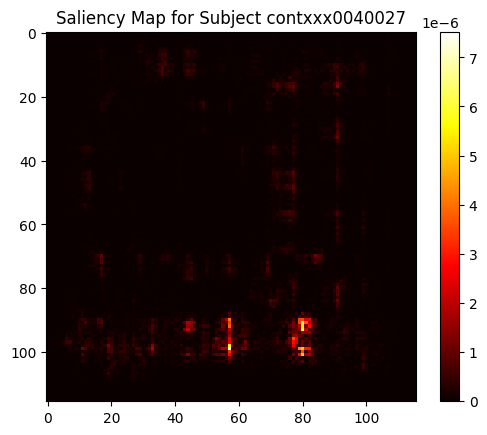

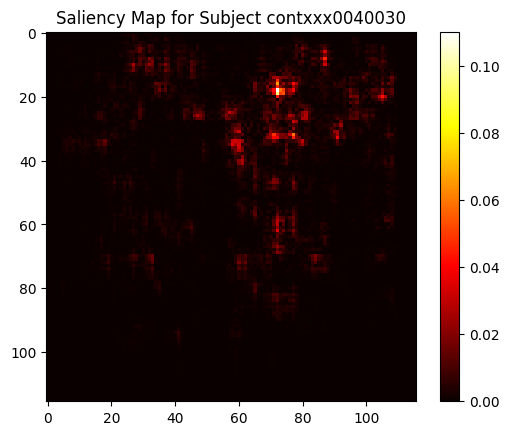

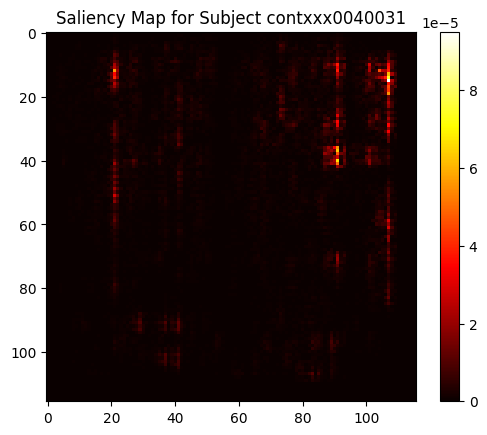

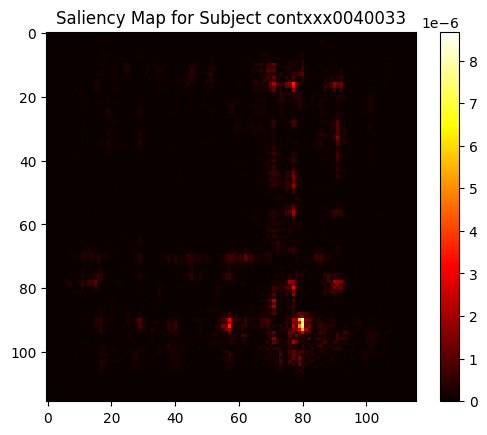

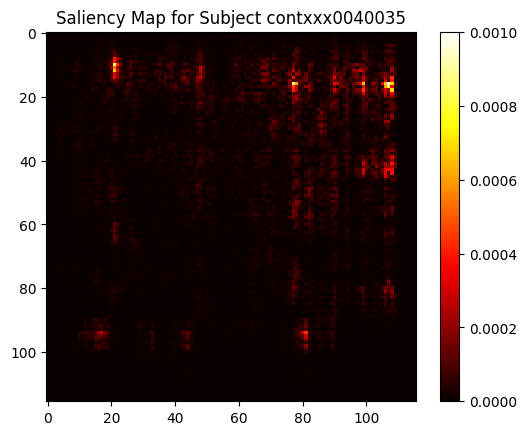

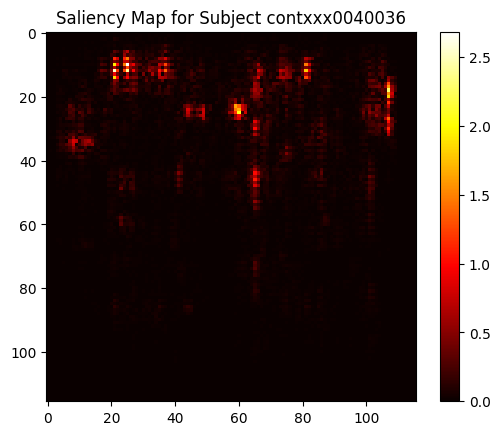

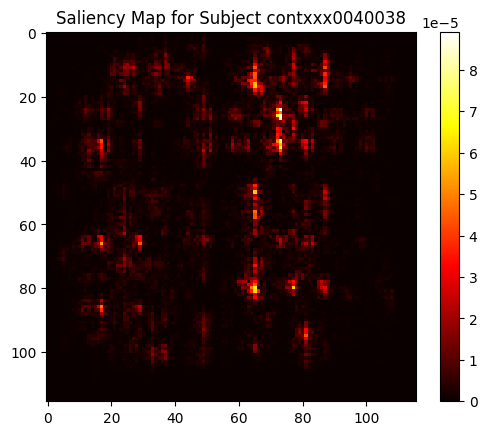

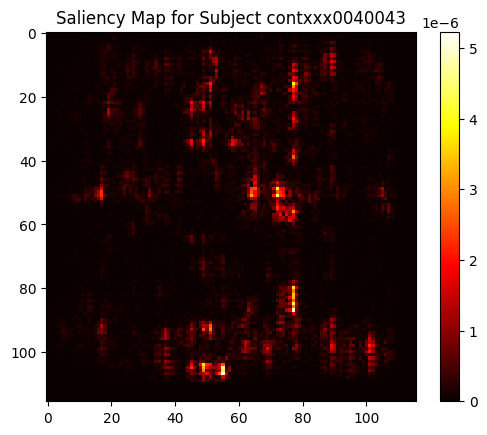

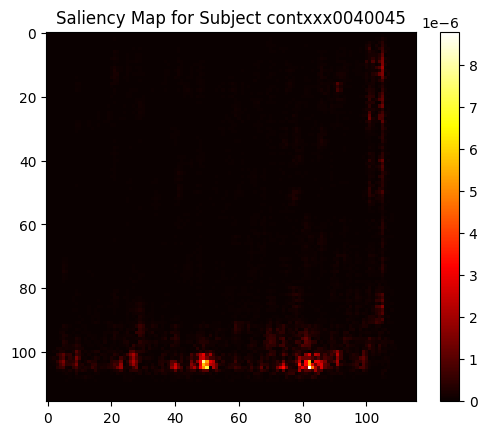

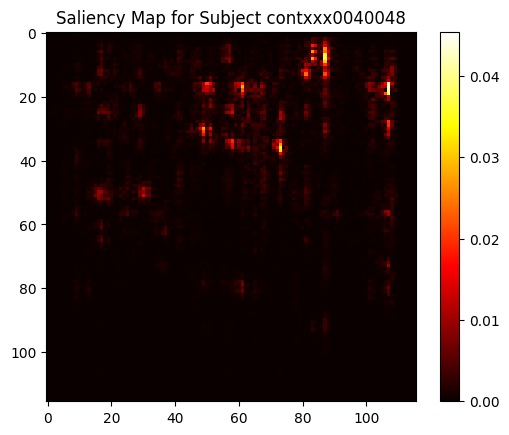

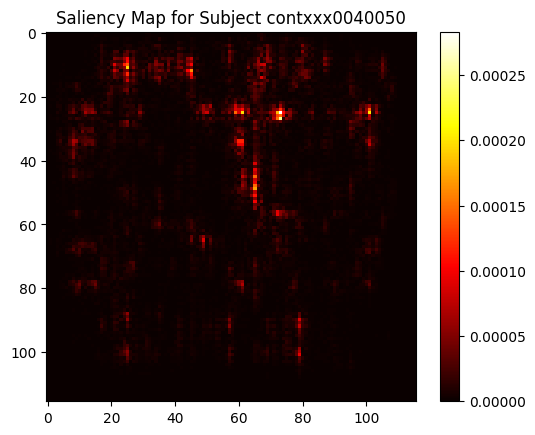

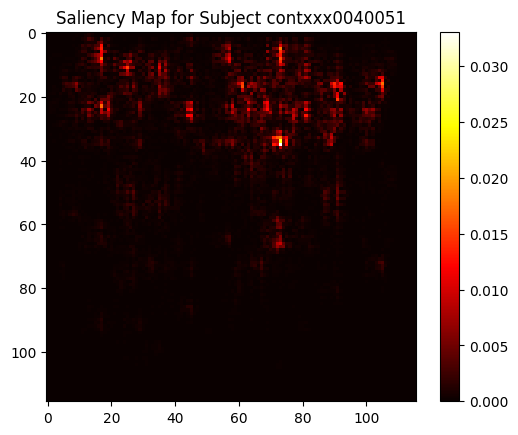

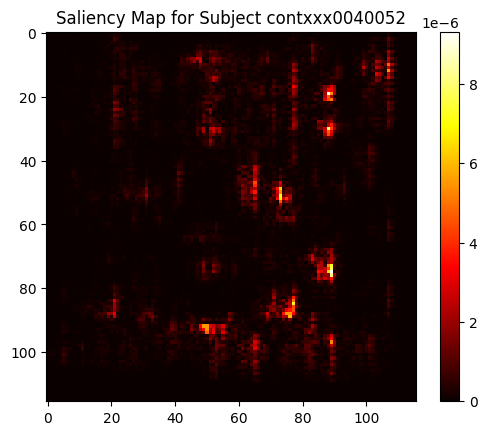

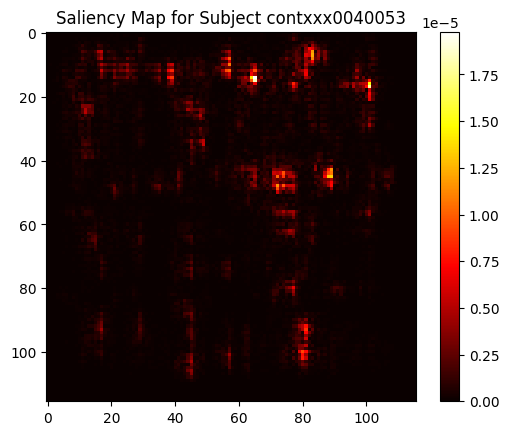

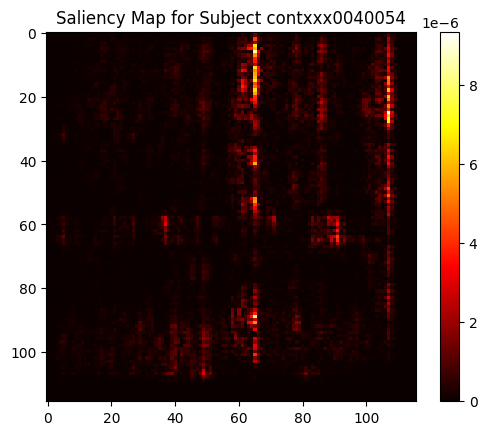

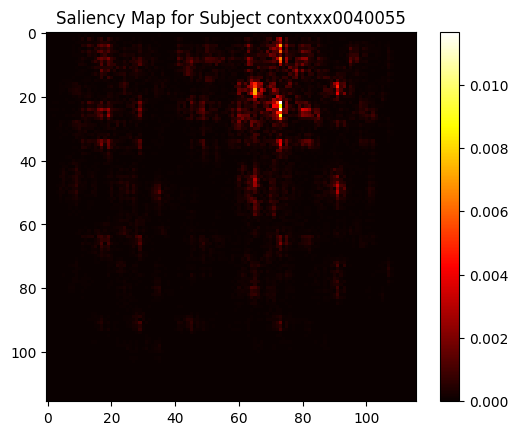

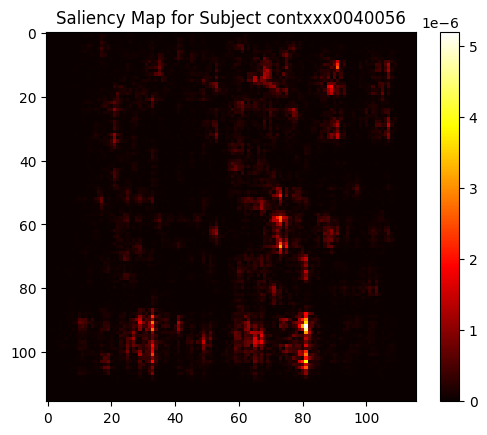

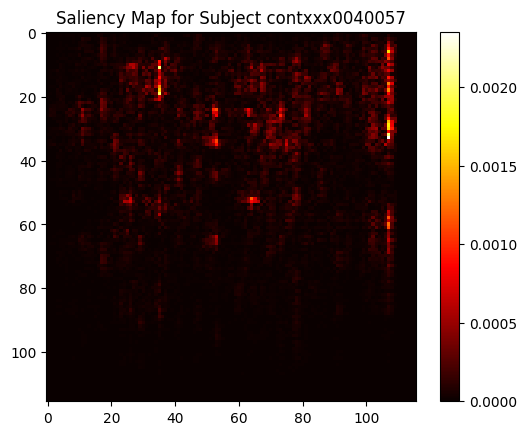

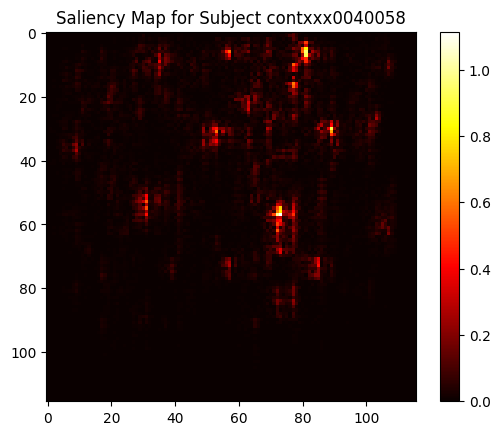

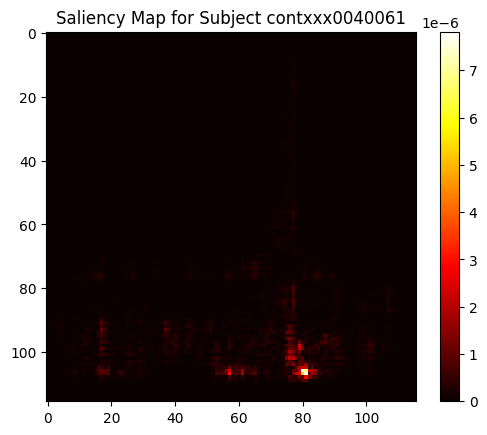

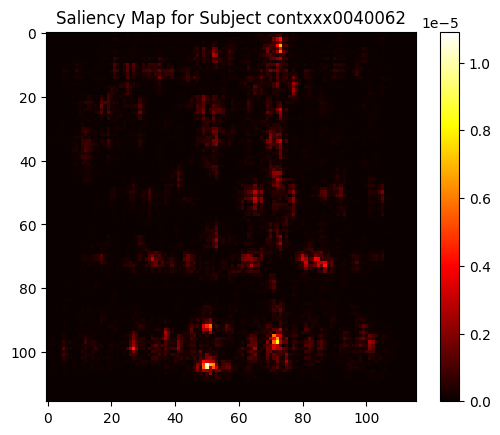

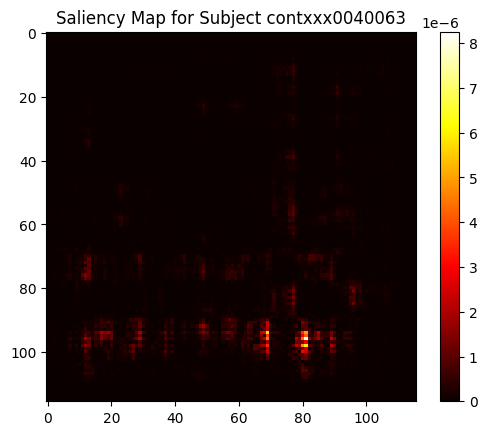

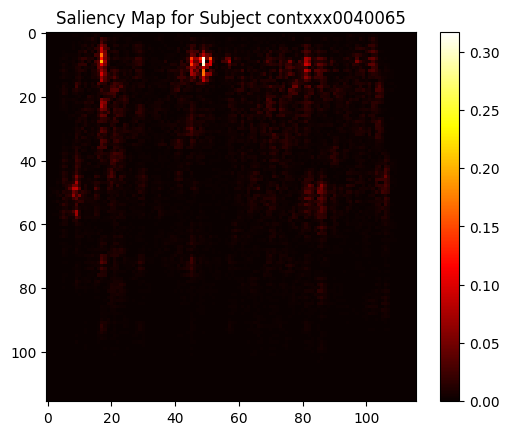

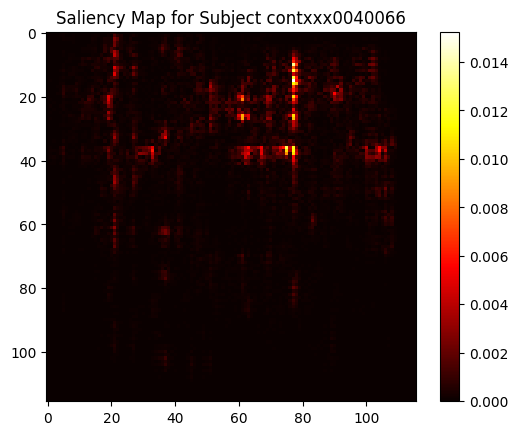

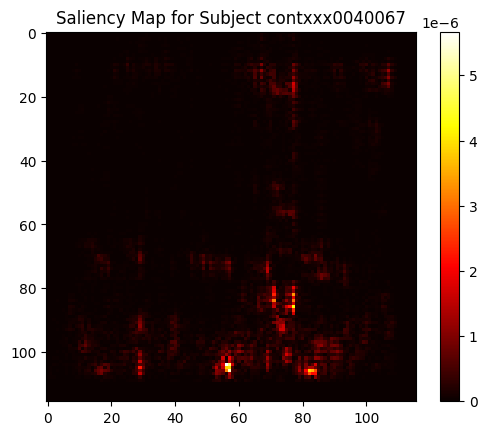

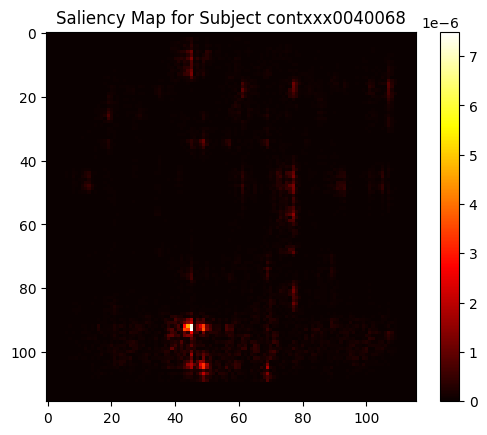

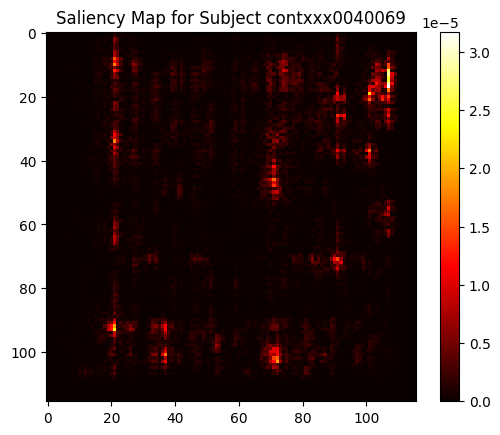

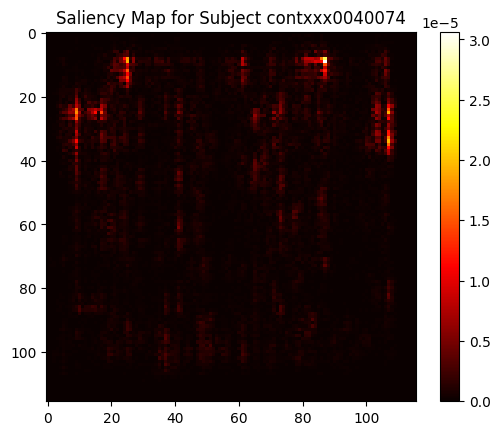

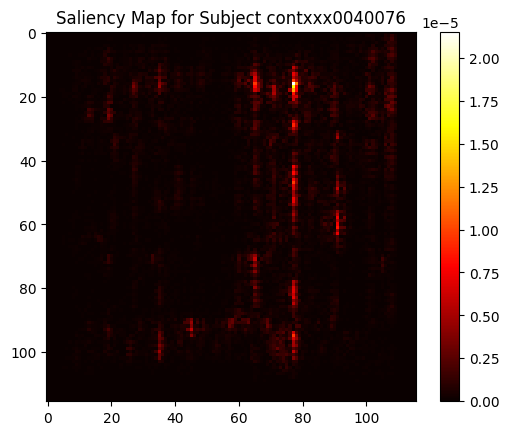

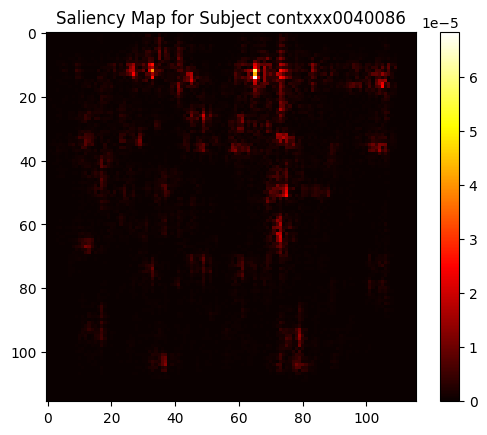

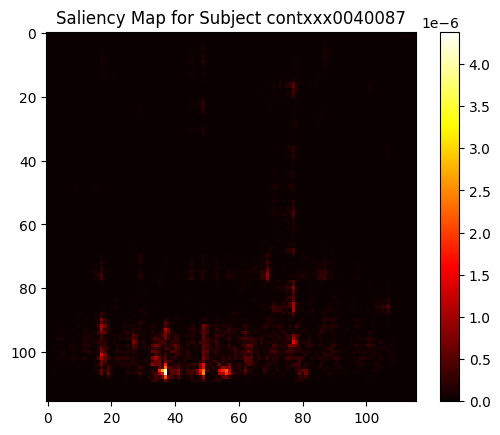

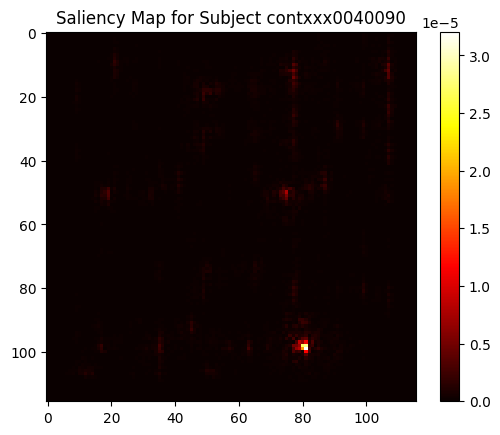

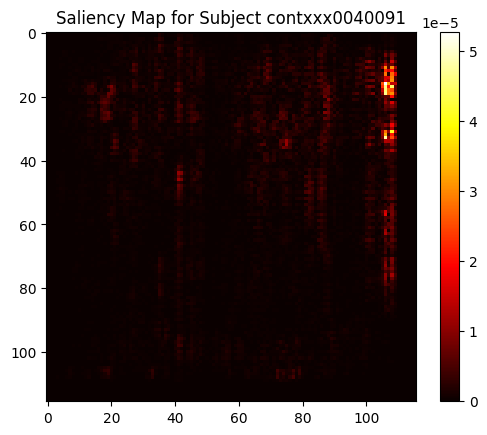

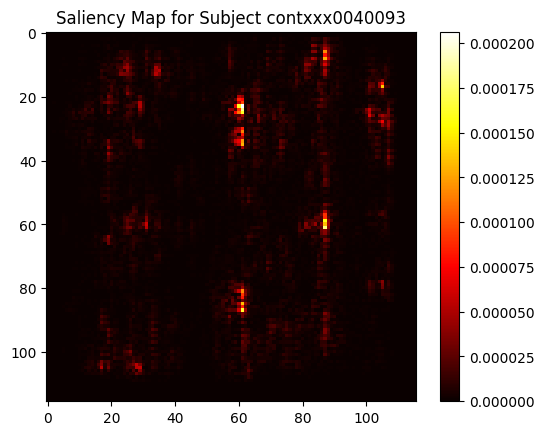

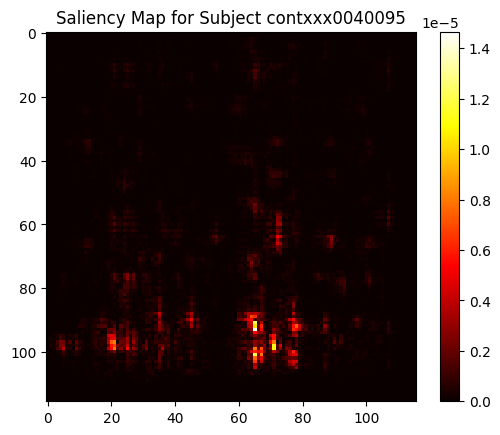

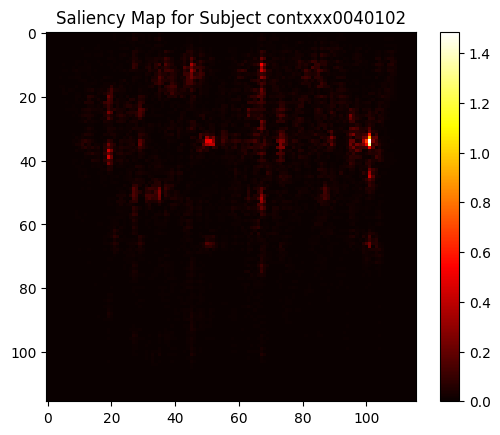

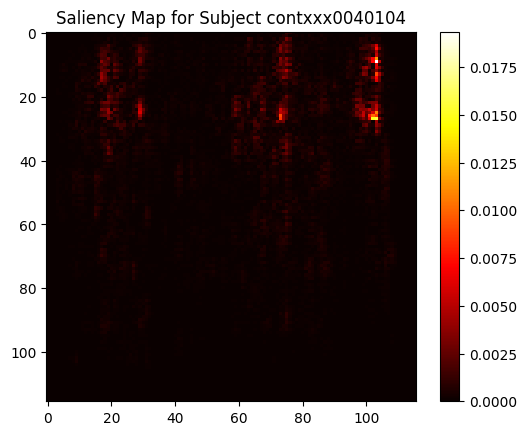

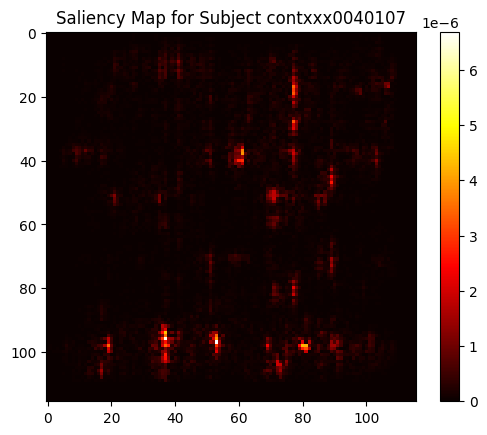

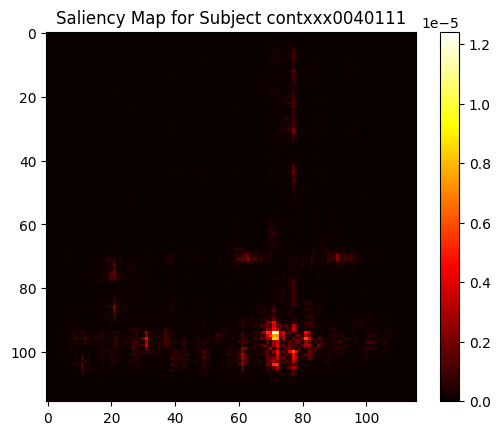

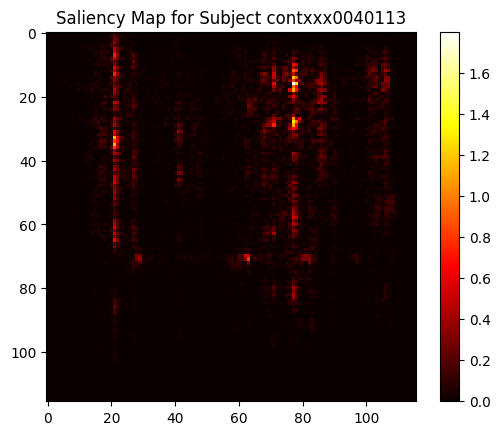

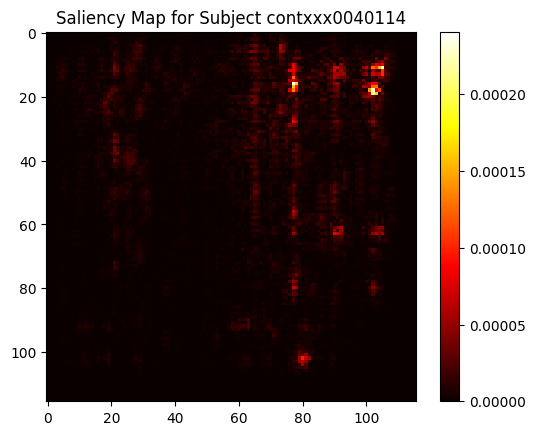

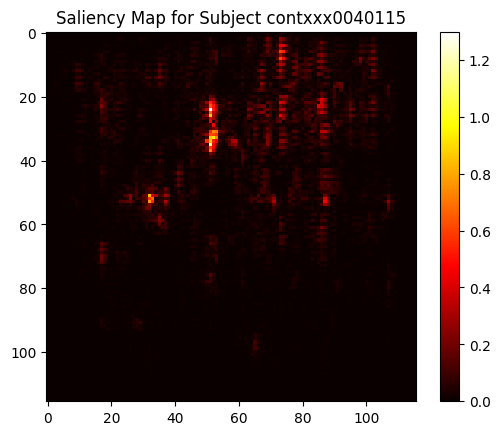

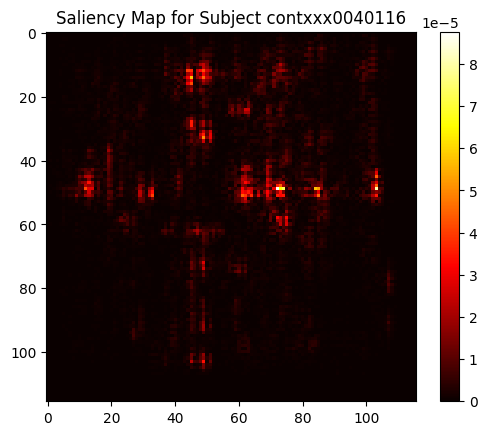

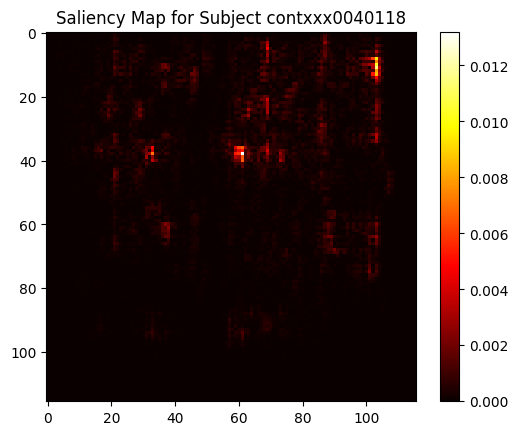

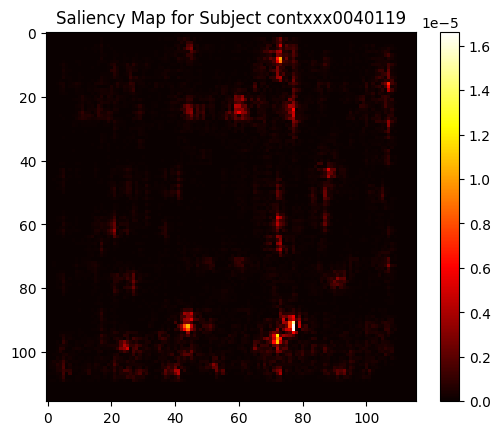

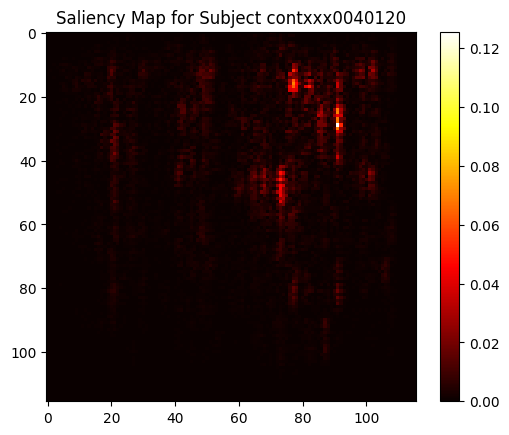

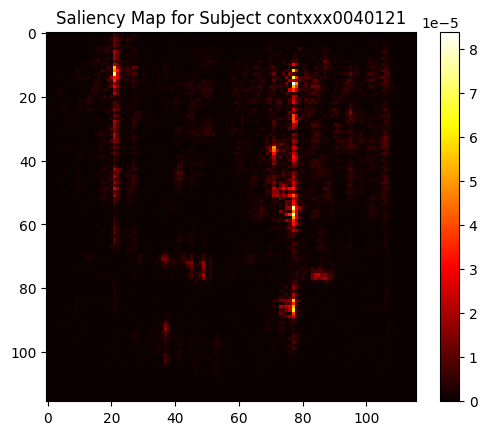

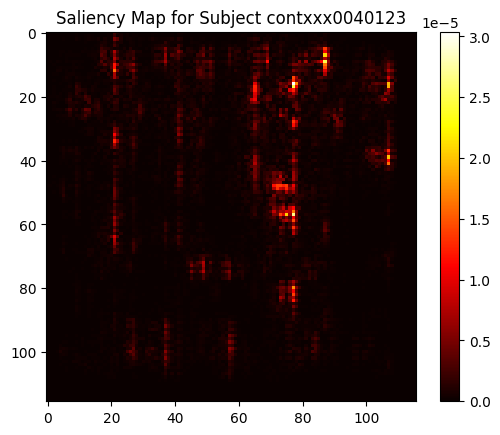

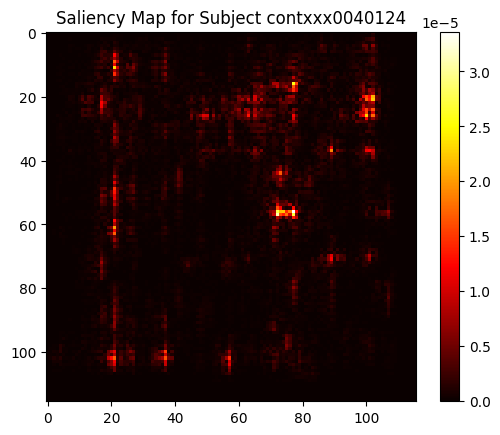

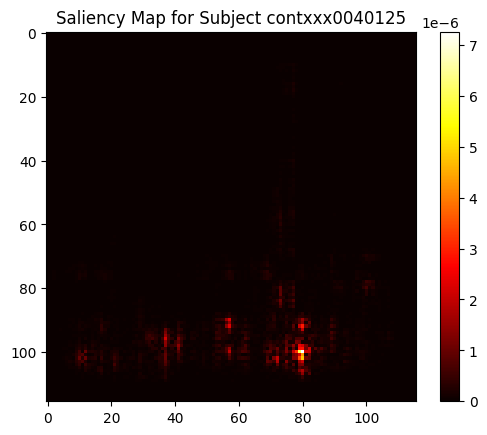

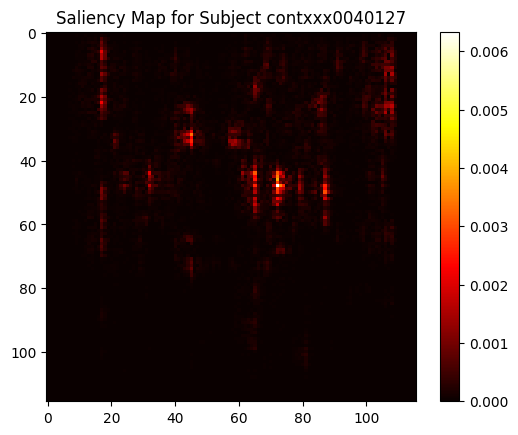

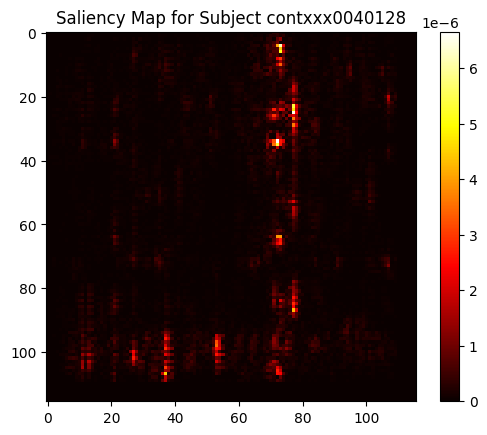

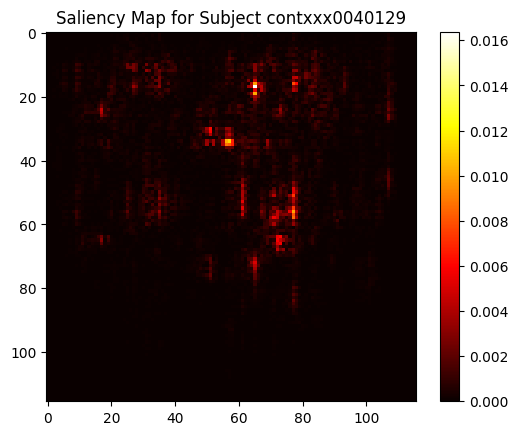

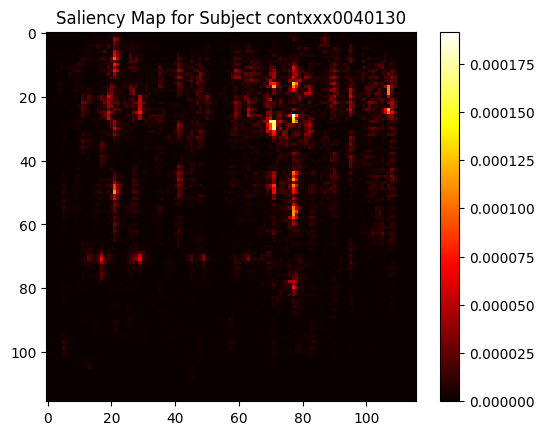

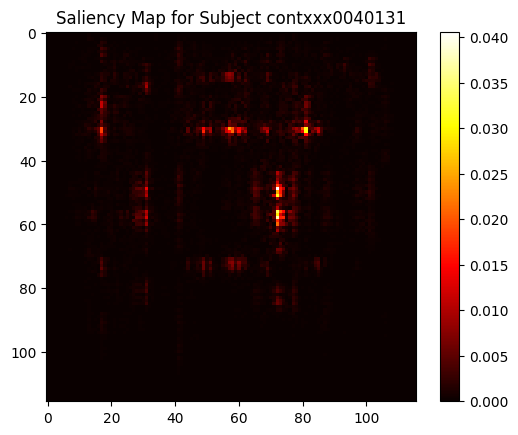

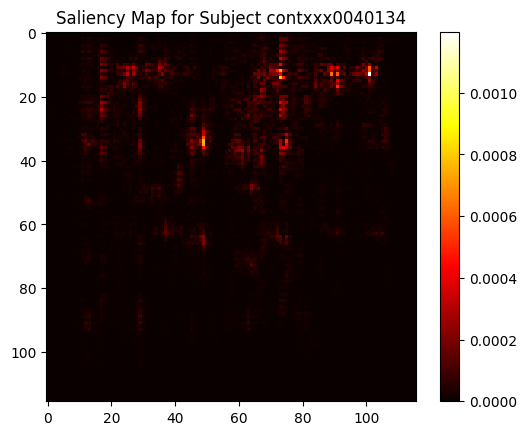

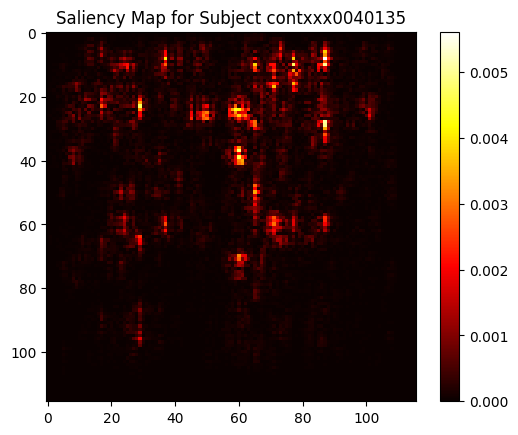

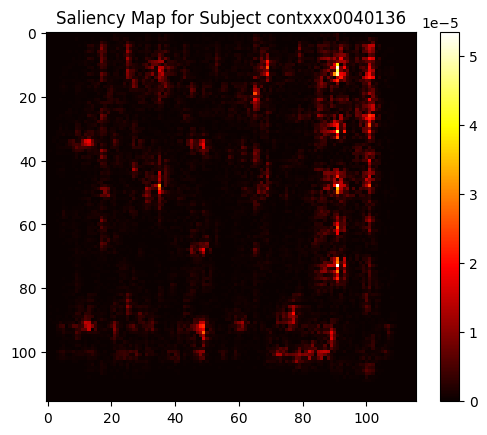

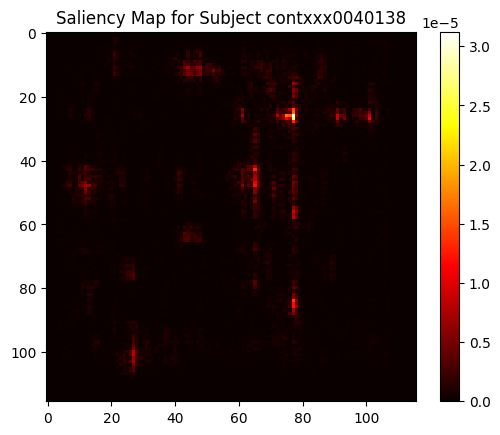

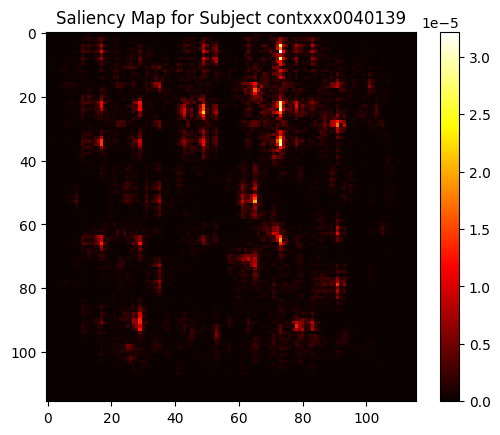

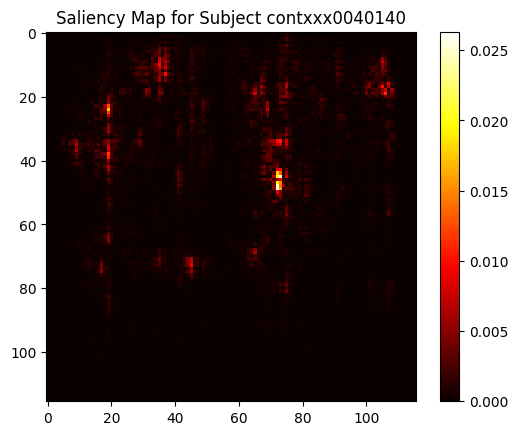

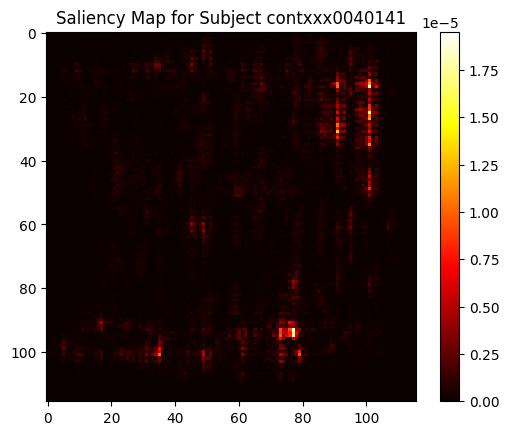

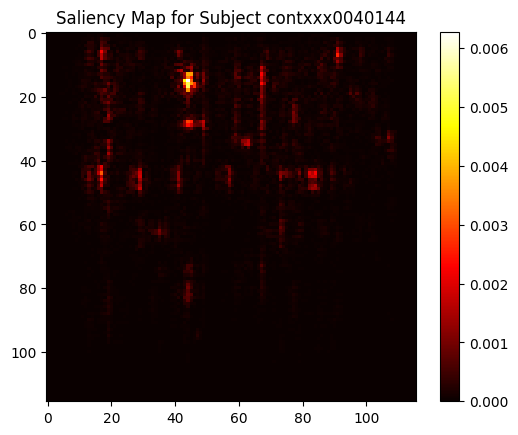

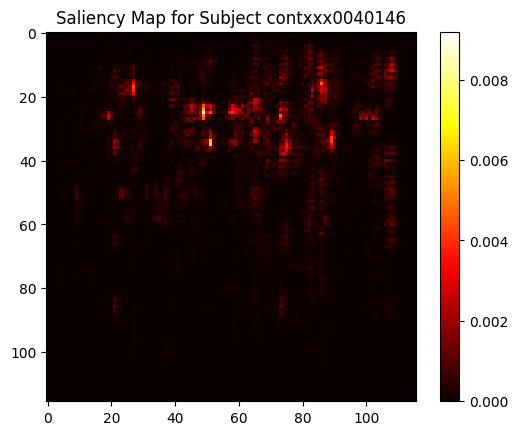

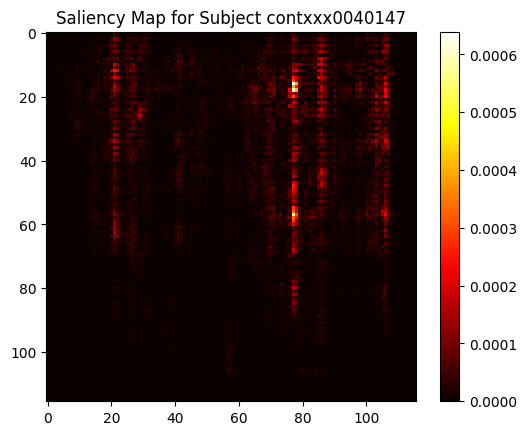

In [ ]:
# Visualize the saliency map for each subject
for i, subject_id in enumerate(list(all_connectivity_matrices.keys())):
    plt.imshow(all_saliency_maps[i], cmap='hot')
    plt.title(f'Saliency Map for Subject {subject_id}')
    plt.colorbar()
    plt.show()


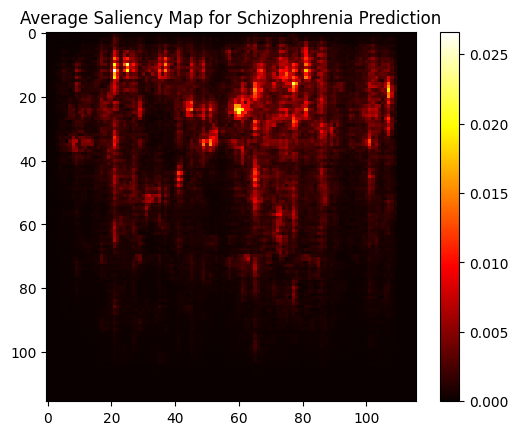

In [ ]:
# Step 1: Compute the average saliency map across all subjects
average_saliency_map = np.mean(all_saliency_maps, axis=0)

# Step 2: Visualize the average saliency map
plt.imshow(average_saliency_map, cmap='hot')
plt.title('Average Saliency Map for Schizophrenia Prediction')
plt.colorbar()
plt.show()


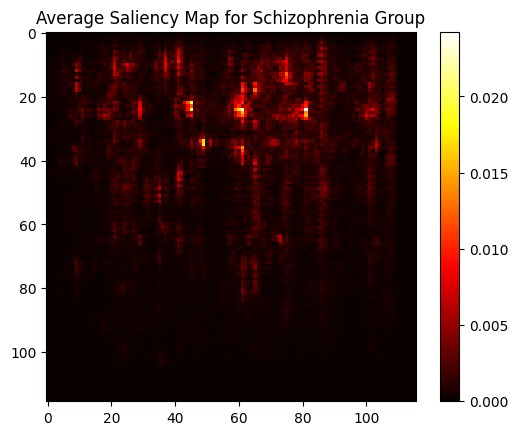

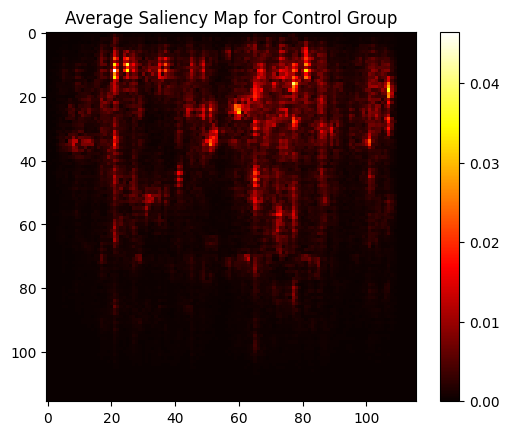

In [ ]:
# Lists to store saliency maps for schizophrenia and control groups
schizophrenia_saliency_maps = []
control_saliency_maps = []

# Separate saliency maps into schizophrenia and control groups
for subject_id, saliency_map in zip(list(all_connectivity_matrices.keys()), all_saliency_maps):
    if subject_id.startswith('szxx'):  # Schizophrenia group
        schizophrenia_saliency_maps.append(saliency_map)
    elif subject_id.startswith('contxx'):  # Control group
        control_saliency_maps.append(saliency_map)

# Step 1: Compute the average saliency map for both groups
average_schizophrenia_saliency = np.mean(schizophrenia_saliency_maps, axis=0)
average_control_saliency = np.mean(control_saliency_maps, axis=0)

# Step 2: Visualize the average saliency map for the schizophrenia group
plt.imshow(average_schizophrenia_saliency, cmap='hot')
plt.title('Average Saliency Map for Schizophrenia Group')
plt.colorbar()
plt.show()

# Step 3: Visualize the average saliency map for the control group
plt.imshow(average_control_saliency, cmap='hot')
plt.title('Average Saliency Map for Control Group')
plt.colorbar()
plt.show()


Difference map connections

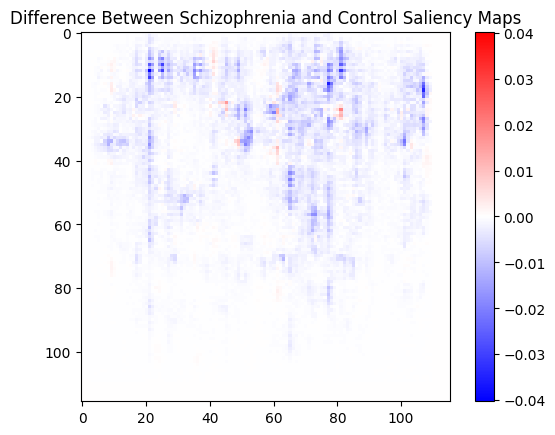

In [ ]:
# Step 4: Compute the difference map between schizophrenia and control groups
difference_map = average_schizophrenia_saliency - average_control_saliency

# Step 5: Visualize the difference map
plt.imshow(difference_map, cmap='bwr', vmin=-np.max(np.abs(difference_map)), vmax=np.max(np.abs(difference_map)))
plt.title('Difference Between Schizophrenia and Control Saliency Maps')
plt.colorbar()
plt.show()


In [ ]:
# Fetch AAL atlas labels
from nilearn import datasets

# Load AAL atlas
atlas = datasets.fetch_atlas_aal()
labels = atlas.labels  # List of 116 region names

# Step 1: Identify the most important connections from the saliency difference map
N = 20  # Number of top connections to find
top_indices = np.unravel_index(np.argsort(difference_map.ravel())[-N:], difference_map.shape)

# Step 2: Print the most important connections between brain regions
for i in range(N):
    roi1 = top_indices[0][i]
    roi2 = top_indices[1][i]
    print(f"Top Connection {i+1}: {labels[roi1]} <-> {labels[roi2]} (Saliency Difference: {difference_map[roi1, roi2]})")


Top Connection 1: Frontal_Med_Orb_L <-> Temporal_Sup_L (Saliency Difference: [0.00577217])
Top Connection 2: Frontal_Sup_Medial_L <-> Calcarine_R (Saliency Difference: [0.00586694])
Top Connection 3: Rectus_R <-> Temporal_Sup_R (Saliency Difference: [0.00596782])
Top Connection 4: ParaHippocampal_L <-> Parietal_Inf_R (Saliency Difference: [0.00609037])
Top Connection 5: Insula_L <-> Parietal_Inf_R (Saliency Difference: [0.00610278])
Top Connection 6: Supp_Motor_Area_L <-> Parietal_Inf_R (Saliency Difference: [0.00616289])
Top Connection 7: Cingulum_Post_L <-> Occipital_Sup_L (Saliency Difference: [0.00652228])
Top Connection 8: Frontal_Mid_Orb_R <-> Amygdala_R (Saliency Difference: [0.00697734])
Top Connection 9: Hippocampus_R <-> Parietal_Inf_R (Saliency Difference: [0.00703789])
Top Connection 10: Frontal_Sup_Medial_L <-> Cuneus_L (Saliency Difference: [0.00720408])
Top Connection 11: Cingulum_Post_R <-> Occipital_Sup_R (Saliency Difference: [0.00821171])
Top Connection 12: Frontal_M

Saleincy map connections

In [ ]:
# Example: Identifying top contributing regions from the saliency map
import numpy as np

# Assume you have the average saliency map (shape 116x116)
saliency_map = average_saliency_map

# Find the indices of the top N important connections
N = 20  # For example, find the top 5 most important connections
top_indices = np.unravel_index(np.argsort(saliency_map.ravel())[-N:], saliency_map.shape)

# Print the most important brain region connections
for i in range(N):
    roi1 = top_indices[0][i]  # First brain region index
    roi2 = top_indices[1][i]  # Second brain region index
    print(f"Important connection {i+1}: {labels[roi1]} <-> {labels[roi2]}")

Important connection 1: Olfactory_L <-> Cerebelum_10_R
Important connection 2: Frontal_Inf_Oper_L <-> Hippocampus_R
Important connection 3: Supp_Motor_Area_L <-> Angular_R
Important connection 4: Cingulum_Post_R <-> Occipital_Mid_R
Important connection 5: Rolandic_Oper_R <-> Cerebelum_10_R
Important connection 6: Frontal_Sup_Medial_R <-> Parietal_Sup_R
Important connection 7: Frontal_Sup_Medial_R <-> Parietal_Inf_L
Important connection 8: Frontal_Inf_Tri_R <-> Olfactory_R
Important connection 9: Frontal_Inf_Tri_L <-> Temporal_Sup_R
Important connection 10: Frontal_Med_Orb_L <-> Parietal_Sup_R
Important connection 11: Frontal_Med_Orb_L <-> Parietal_Inf_R
Important connection 12: Supp_Motor_Area_L <-> Cerebelum_10_R
Important connection 13: Frontal_Inf_Orb_L <-> Olfactory_R
Important connection 14: Frontal_Inf_Tri_L <-> Frontal_Med_Orb_R
Important connection 15: Frontal_Inf_Oper_L <-> Olfactory_R
Important connection 16: Frontal_Med_Orb_R <-> Parietal_Inf_L
Important connection 17: Front

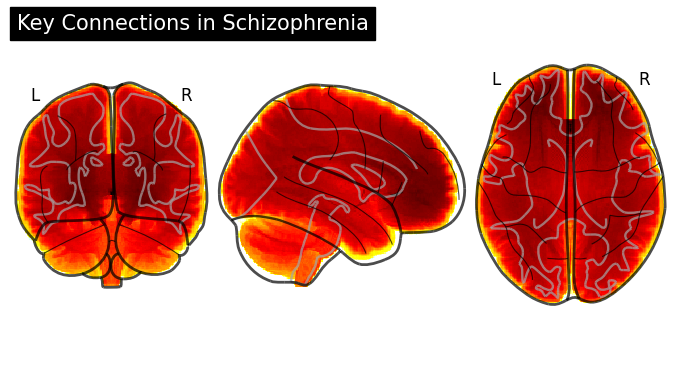

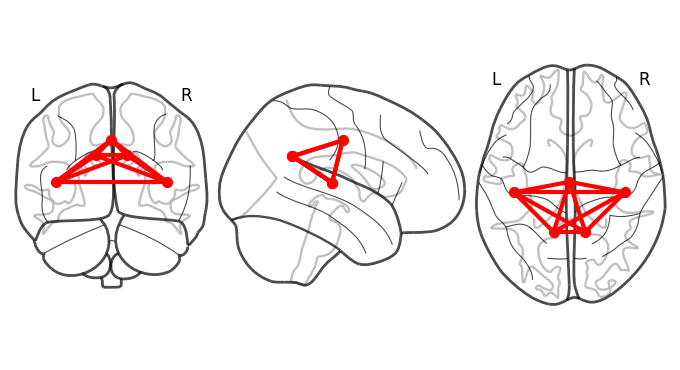

In [ ]:
from nilearn import plotting
from nilearn import datasets

# Load the MNI152 template for the brain image
template = datasets.load_mni152_template()

# Example: Coordinates for ROIs (replace with actual MNI coordinates for your ROIs)

# These can be obtained from the AAL atlas or other neuroimaging tools
coordinates = [
    (12, -52, 28),  # Thalamus_R (example coordinates, replace with actual ones)
    (-12, -52, 28),  # Thalamus_L
    (42, -22, 8),  # Heschl_R
    (-42, -22, 8),  # Heschl_L
    (0, -14, 40),  # Caudate_R
    # Add more coordinates for the other important regions
]

# Plot the important brain regions and connections
plotting.plot_glass_brain(template, display_mode='ortho', plot_abs=False, title="Key Connections in Schizophrenia")
plotting.plot_connectome(np.ones((len(coordinates), len(coordinates))), coordinates, edge_threshold="90%", node_color='red')
plotting.show()

<ipython-input-99-b5703ab4ada5>:47: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  plotting.plot_connectome(connectivity_matrix, coordinates, edge_threshold="80%", node_color='red', display_mode='lyrz')


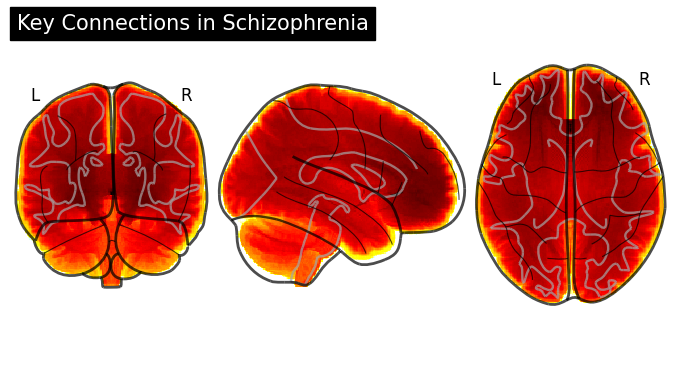

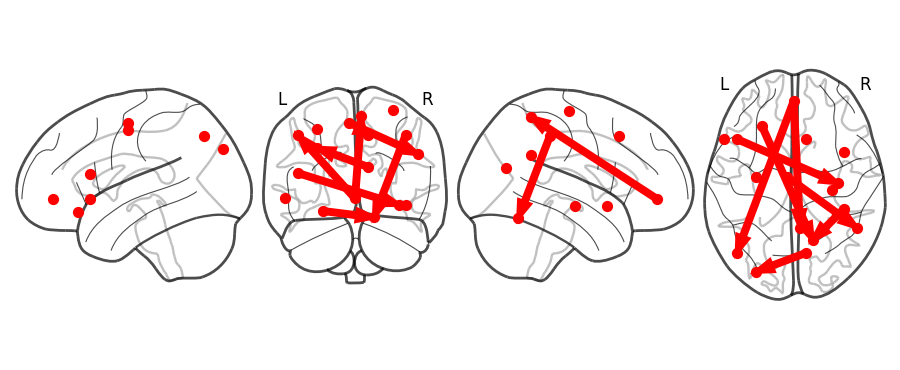

In [ ]:
from nilearn import plotting, datasets
import numpy as np

# Load the MNI152 template for the brain image
template = datasets.load_mni152_template()

# Example: Coordinates for ROIs (replace these placeholders with actual MNI coordinates for your ROIs)
# Coordinates for important brain regions (e.g., Olfactory, Frontal_Inf_Oper, etc.)
coordinates = [
    (-25, 30, -15),  # Olfactory_L
    (15, -60, -20),  # Cerebelum_10_R
    (-45, 20, 15),   # Frontal_Inf_Oper_L
    (35, -15, -10),  # Hippocampus_R
    (-5, -10, 55),   # Supp_Motor_Area_L
    (50, -50, 30),   # Angular_R
    (10, -70, 20),   # Cingulum_Post_R
    (-30, -85, 35),  # Occipital_Mid_R
    (40, -35, 45),   # Rolandic_Oper_R
    (0, 50, -5),     # Frontal_Sup_Medial_R
    (5, -50, 60),    # Parietal_Sup_R
    (-45, -70, 45),  # Parietal_Inf_L
    (-30, -10, 50),  # Frontal_Med_Orb_L
    (40, 10, -10),   # Frontal_Inf_Tri_R
    (10, 20, 45),    # Olfactory_R
    (-55, 20, -5),   # Frontal_Inf_Tri_L
    (30, -20, 65),   # Temporal_Sup_R
]

# Create a connectivity matrix with all the connections between the important regions
connectivity_matrix = np.zeros((len(coordinates), len(coordinates)))

# Mark the connections (manually or based on your findings)
# Set connections between the ROIs (for simplicity, using value 1)
connectivity_matrix[0, 1] = 1  # Olfactory_L <-> Cerebelum_10_R
connectivity_matrix[2, 3] = 1  # Frontal_Inf_Oper_L <-> Hippocampus_R
connectivity_matrix[4, 5] = 1  # Supp_Motor_Area_L <-> Angular_R
connectivity_matrix[6, 7] = 1  # Cingulum_Post_R <-> Occipital_Mid_R
connectivity_matrix[8, 1] = 1  # Rolandic_Oper_R <-> Cerebelum_10_R
connectivity_matrix[9, 10] = 1  # Frontal_Sup_Medial_R <-> Parietal_Sup_R
connectivity_matrix[9, 11] = 1  # Frontal_Sup_Medial_R <-> Parietal_Inf_L
# (Add other connections similarly...)

# Plot the important brain regions and connections on the glass brain
plotting.plot_glass_brain(template, display_mode='ortho', plot_abs=False, title="Key Connections in Schizophrenia")

# Plot the connectome with the specified coordinates and connections
plotting.plot_connectome(connectivity_matrix, coordinates, edge_threshold="80%", node_color='red', display_mode='lyrz')

# Show the plots
plotting.show()
